In [1]:
# !pip install tensorflow
# !pip install xgboost
# !pip install imblearn
# !pip install shap

In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from matplotlib import rcParams
from IPython.display import display, Markdown, Latex
from pylab import *
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pickle as pk
import random 
import warnings
import plotly.express as px
import shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import feature_selection
from sklearn import linear_model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import backend as B
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline


# create custom colour array and set theme
colors = ["#0047AB", "#6495ED", "#4374B3"]
sns.set_theme(style="whitegrid", palette=colors)

# Exploratory Data Analysis

In [3]:
# Load Data
data = pd.read_csv('cleaned_data.csv', low_memory=False) 
audio_ft = pd.read_csv('/project/audio_features.csv')

print("Number of rows of original data:", len(data))
print("Number of rows of audio features data:", len(audio_ft))

Number of rows of original data: 3805499
Number of rows of audio features data: 4618


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3805499 entries, 0 to 3805498
Data columns (total 45 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Unnamed: 0.1       int64  
 2   Unnamed: 0.1.1     object 
 3   day                int64  
 4   log_time           object 
 5   mobile             bool   
 6   track_id           object 
 7   isrc               object 
 8   upc                float64
 9   artist_name        object 
 10  track_name         object 
 11  album_name         object 
 12  customer_id        object 
 13  postal_code        object 
 14  access             object 
 15  country_code       object 
 16  gender             object 
 17  birth_year         float64
 18  filename           object 
 19  region_code        object 
 20  referral_code      float64
 21  partner_name       object 
 22  financial_product  object 
 23  user_product_type  object 
 24  offline_timestamp  float64
 25  stream_length     

In [5]:
audio_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4618 entries, 0 to 4617
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4618 non-null   int64  
 1   track_uri         4618 non-null   object 
 2   danceability      4618 non-null   float64
 3   energy            4618 non-null   float64
 4   key               4618 non-null   int64  
 5   loudness          4618 non-null   float64
 6   mode              4618 non-null   int64  
 7   speechiness       4618 non-null   float64
 8   acousticness      4618 non-null   float64
 9   instrumentalness  4618 non-null   float64
 10  liveness          4618 non-null   float64
 11  valence           4618 non-null   float64
 12  tempo             4618 non-null   float64
 13  duration_ms       4618 non-null   int64  
 14  time_signature    4618 non-null   int64  
dtypes: float64(9), int64(5), object(1)
memory usage: 541.3+ KB


In [6]:
# merge original data with audio features
data.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace = True)
big_data = pd.merge(data, audio_ft, how='outer', left_on = ['track_uri'], right_on= ['track_uri'])
print("Number of rows of merged dataset:", len(big_data))

Number of rows of merged dataset: 3805499


In [7]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3805499 entries, 0 to 3805498
Data columns (total 56 columns):
 #   Column             Dtype  
---  ------             -----  
 0   day                int64  
 1   log_time           object 
 2   mobile             bool   
 3   track_id           object 
 4   isrc               object 
 5   upc                float64
 6   artist_name        object 
 7   track_name         object 
 8   album_name         object 
 9   customer_id        object 
 10  postal_code        object 
 11  access             object 
 12  country_code       object 
 13  gender             object 
 14  birth_year         float64
 15  filename           object 
 16  region_code        object 
 17  referral_code      float64
 18  partner_name       object 
 19  financial_product  object 
 20  user_product_type  object 
 21  offline_timestamp  float64
 22  stream_length      float64
 23  stream_cached      float64
 24  stream_source      object 
 25  stream_source_uri 

In [8]:
big_data.drop(['Unnamed: 0'], axis=1, inplace = True)

In [9]:
# select relevant playlists 
target_playlists = ['Hot Hits UK', 'Massive Dance Hits', 'The Indie List', 'New Music Friday']

In [10]:
# total number of successful and unsuccessful streams
big_data['Success'] = np.where(big_data.playlist_name.isin(target_playlists), 1, 0) 
print("Number of successful and unsuccessful streams:")
big_data['Success'].value_counts()

Number of successful and unsuccessful streams:


0    3602720
1     202779
Name: Success, dtype: int64

In [11]:
big_data.drop(['Success'], axis=1, inplace=True)

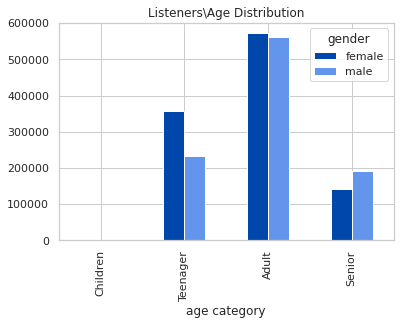

In [12]:
big_data['birth_year'] = 2022 - big_data['birth_year']
big_data.rename(columns = {'birth_year':'age'}, inplace = True)

big_data['age'].dropna(inplace = True)
age_bins_df = big_data[["artist_name", "customer_id", "age","gender"]]
age_bins_df = age_bins_df.drop_duplicates(subset = ['customer_id'])
bins = [0, 18, 25, 40, 70]
group_names = ['Children', 'Teenager', 'Adult', 'Senior']

age_bins_df['age category'] = pd.cut(x=age_bins_df['age'], bins = bins, labels = group_names) 
age_bins_df = age_bins_df.set_index('artist_name') 

age_graph = age_bins_df.groupby(["age category", 'gender']).size().unstack(level=1).plot(kind='bar')
age_graph.set(title='Listeners\Age Distribution')
              
age_counts = age_bins_df["age category"].value_counts()
              
fig = px.bar(age_counts, title="Age Distribution of Listeners")
fig.update_layout(
    xaxis_title = "Age Category",
    yaxis_title = "Unique Listeners number",
    title_x = 0.5, 
    showlegend = False
)
fig.show()

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:

invalid value encountered in greater_equal

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:

invalid value encountered in less_equal



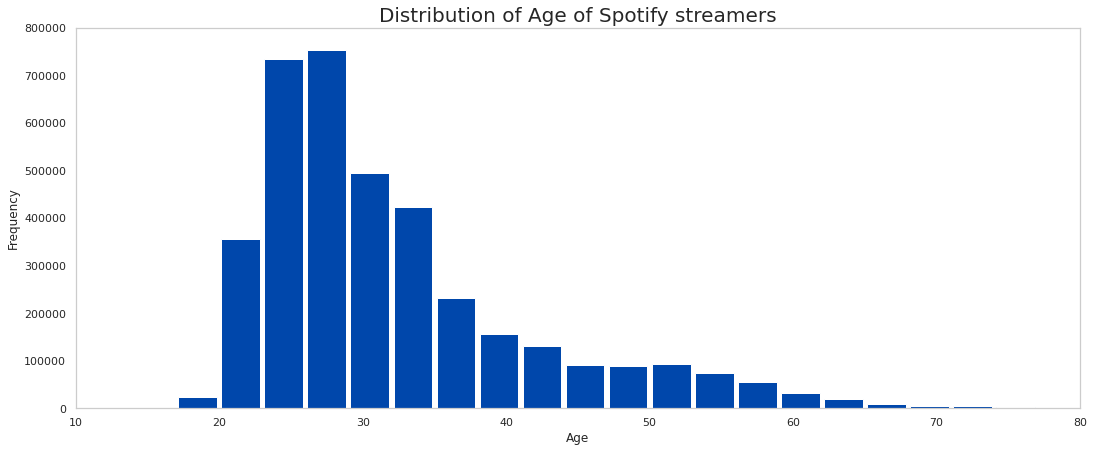

In [13]:
# visualize age distribution
plt.rcParams['figure.figsize'] = (18, 7)
plt.hist(big_data['age'], bins = 50, rwidth = 0.9)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age of Spotify streamers', fontsize = 20)
plt.axis([10, 80, 0, 800000])
plt.grid(False)

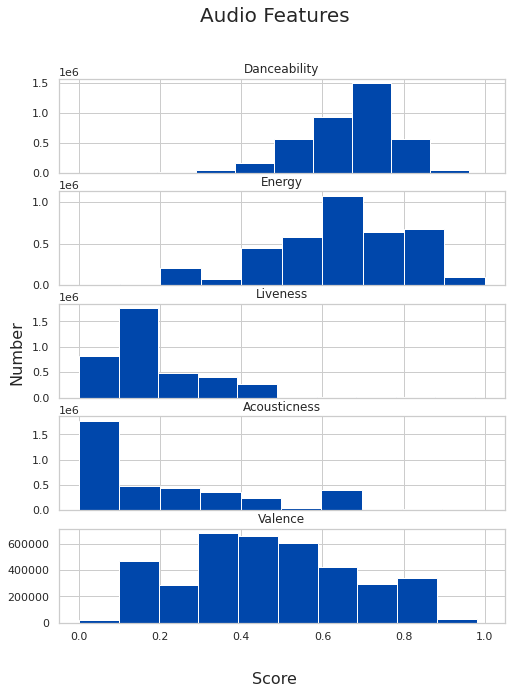

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(8, 10), sharex=True)
fig.text(0.5, 0.04, 'Score', ha='center',size=16)
fig.text(0.04, 0.5, 'Number', va='center', rotation='vertical',size=16)
axs[0].hist(big_data['danceability'])
axs[0].set_title('Danceability')
axs[1].hist(big_data['energy'])
axs[1].set_title('Energy')
axs[2].hist(big_data['liveness'])
axs[2].set_title('Liveness')
axs[3].hist(big_data['acousticness'])
axs[3].set_title('Acousticness')
axs[4].hist(big_data['valence'])
axs[4].set_title('Valence')
fig.suptitle('Audio Features',size=20)
plt.show()

In [15]:
gender_count = big_data[['customer_id', 'gender']]
gender_count = gender_count.groupby('gender').nunique()
gender_count = gender_count.rename(columns = {'customer_id':'count_user'})

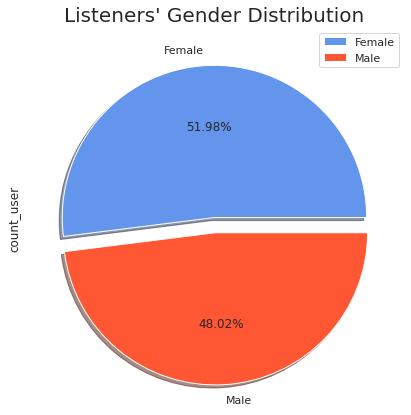

In [16]:
labels = ['Female','Male']
explode = (0, 0.1)
gender_count.plot(kind='pie', labels=labels, shadow=True, subplots=True, colors = ['#6495ED', '#FF5733'], explode=explode, figsize=(7, 7), autopct = '%.2f%%')
plt.title('Listeners\' Gender Distribution', fontsize = 20);
plt.show()

In [17]:
# total number of successful and unsuccessful streams
big_data['Success'] = np.where(big_data.playlist_name.isin(target_playlists), 1, 0) 
big_data['Success'].value_counts()

big_data['Successful'] = np.where(big_data['Success'] > 0, 1, 0) 
big_data['Successful'].value_counts()

big_data.drop(['Success'], axis=1, inplace=True)

In [18]:
successful_count = big_data[big_data.Successful == 1]

success_count = successful_count[['customer_id', 'gender']]
success_count = success_count.groupby('gender').nunique()
success_count = success_count.rename(columns = {'customer_id':'count_user'})

unsuccessful_count = big_data[big_data.Successful == 0]

unsuccess_count = unsuccessful_count[['customer_id', 'gender']]
unsuccess_count = unsuccess_count.groupby('gender').nunique()
unsuccess_count = unsuccess_count.rename(columns = {'customer_id':'count_user'})

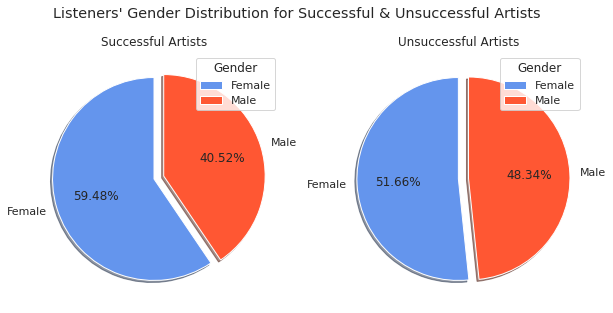

In [19]:
explode = (0, 0.1) # only "explode" the 2nd slice (i.e. 'Red Wine')
labels = ["Female", "Male"]
colors = ['#6495ED', '#FF5733']

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Listeners\' Gender Distribution for Successful & Unsuccessful Artists')

success_count.count_user.plot(labels=labels, colors=colors, kind='pie', autopct='%1.2f%%', shadow=True, startangle=90, explode=explode, figsize=(10, 5), ax=ax[0])
ax[0].legend(labels=labels,title = "Gender", loc="upper right")
ax[0].set_ylabel(" ", fontsize = 13)

unsuccess_count.count_user.plot(labels=labels, colors=colors, kind='pie', autopct='%1.2f%%', shadow=True, startangle=90, explode=explode, figsize=(10, 5), ax=ax[1])
ax[1].legend(labels=labels,title = "Gender", loc="upper right")
ax[1].set_ylabel(" ", fontsize = 13)

ax[0].set_title('Successful Artists')
ax[1].set_title('Unsuccessful Artists')

fig.show()

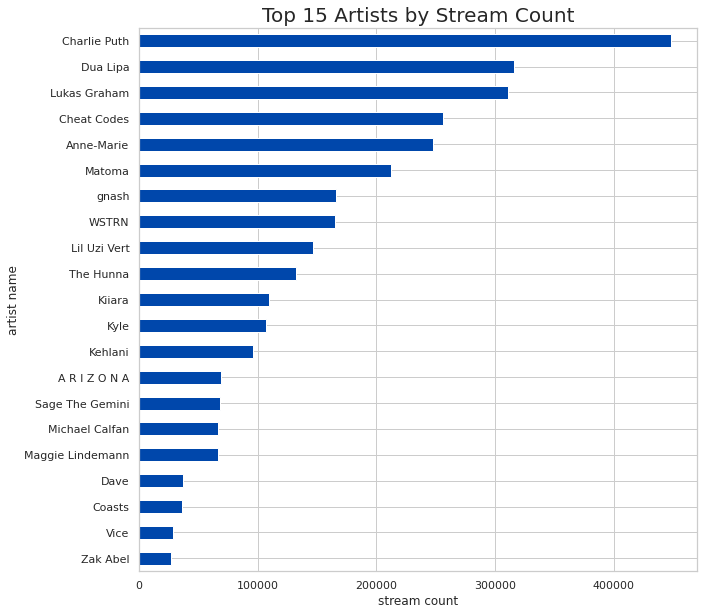

In [20]:
top_artists = big_data['artist_name'].value_counts()[0:21]

top_artists.sort_values().plot(kind = 'barh', figsize=(10,10));
plt.xlabel('stream count')
plt.ylabel('artist name')
plt.title('Top 15 Artists by Stream Count', fontsize = 20);

In [21]:
playlist_data1 = DataFrame(big_data['playlist_name'].value_counts())
playlist_data2 = playlist_data1.drop(playlist_data1.index[15:] )
playlist_data3 = playlist_data2.rename(columns = {'playlist_name':'Number of streams'})
playlist_data3 

Number of streams
Hot Hits UK                                  193654
Today's Top Hits                             105383
Topsify UK Top 40                             54982
Freshness: Hot House Music                    32961
The Pop List                                  28630
New Music Monday UK                           27793
Happy Hits!                                   18767
Summer Hits                                   16822
Top Tracks in The United Kingdom              15524
You've Got Male - R&B: The Men                14777
#MondayMotivation                             12727
Radio 1 Playlist (BBC)                        12387
Rap Caviar                                    11952
Totally Tropical House                        11804
Mellow Pop                                    11078

Text(0.5, 1.0, 'Top 15 Playlist by Stream Count')

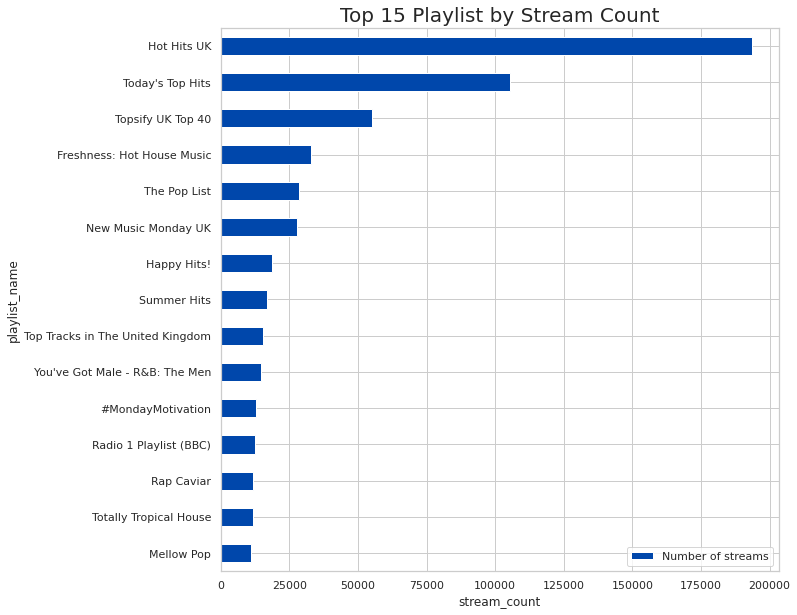

In [22]:
playlist_data3.sort_values(by ='Number of streams').plot(kind = 'barh', figsize=(10,10));
plt.xlabel('stream_count')
plt.ylabel('playlist_name')
plt.title('Top 15 Playlist by Stream Count', fontsize = 20)

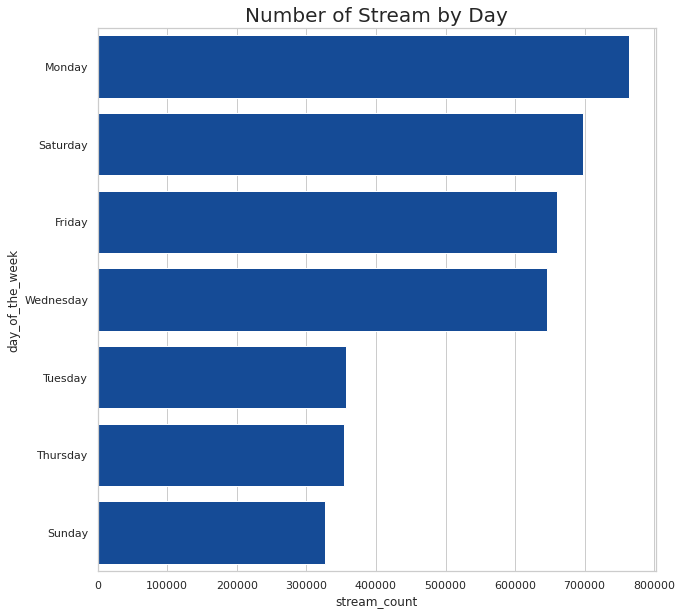

In [23]:
rcParams['figure.figsize'] = 10,10
sns.countplot(y = 'weekday_name',
              data = big_data,
              order = big_data['weekday_name'].value_counts().index, color = '#0047AB')
plt.title('Number of Stream by Day', fontsize = 20)
plt.xlabel('stream_count', fontsize = 12)
plt.ylabel('day_of_the_week', fontsize = 12);

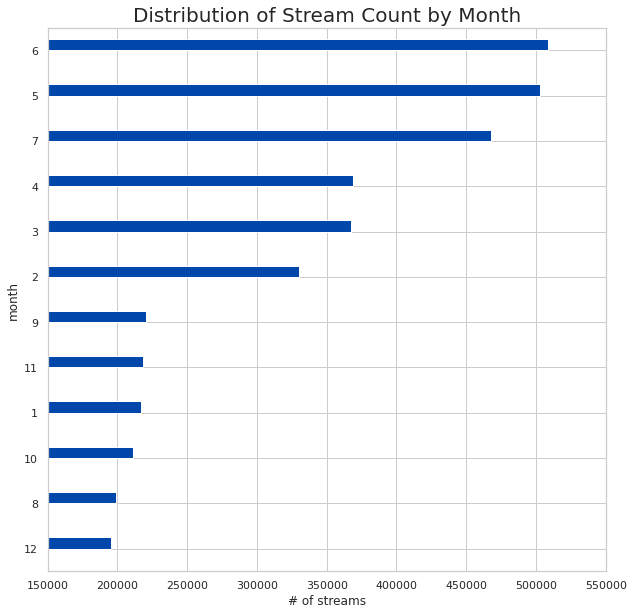

In [24]:
streams_by_month = big_data.groupby('month').count()
streams_by_month['Month'] = streams_by_month.index
streams_by_month = streams_by_month.sort_values('year')

streams_by_month_plot = streams_by_month[['Month', 'day']].plot(kind='barh', color= '#0047AB', figsize = (10, 10), legend = False, fontsize = 11)
streams_by_month_plot .set_xlim((150000, 550000))
streams_by_month_plot.set_xlabel("# of streams")
plt.title('Distribution of Stream Count by Month', fontsize=20);

In [25]:
audio_ft = big_data.drop_duplicates(subset=['track_id', 'playlist_id'])

Text(0.5, 1.0, 'Loudness by Speechiness')

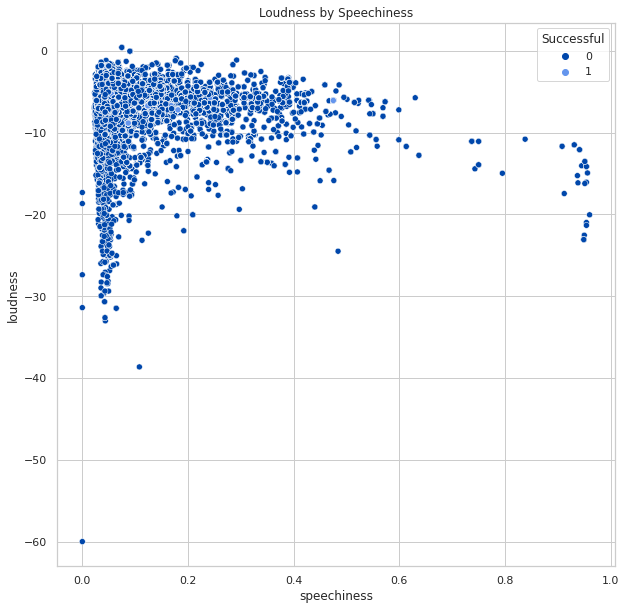

In [26]:
sns.scatterplot(data=audio_ft, x="speechiness", y="loudness", hue="Successful")
plt.title("Loudness by Speechiness")

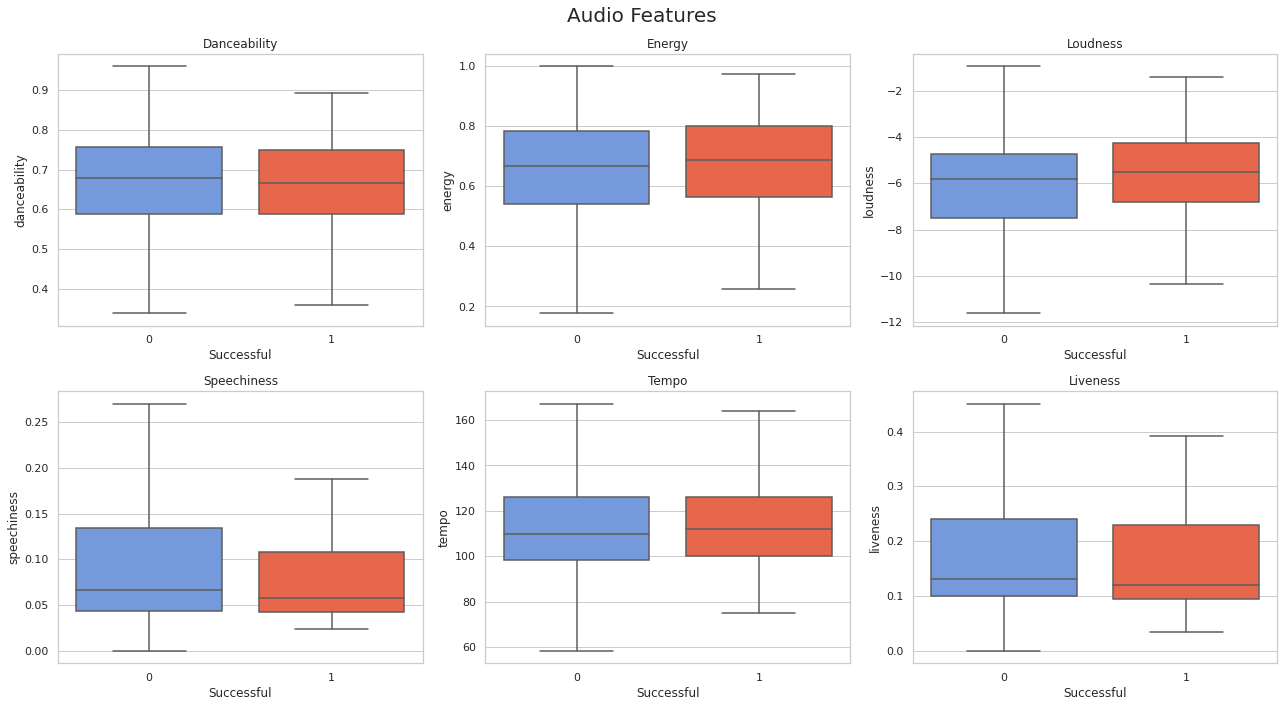

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Audio Features', fontsize=20)

sns.boxplot(ax=axes[0, 0], data=audio_ft, x='Successful', y='danceability', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Danceability')
sns.boxplot(ax=axes[0, 1], data=audio_ft, x='Successful', y='energy', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Energy')
sns.boxplot(ax=axes[0, 2], data=audio_ft, x='Successful', y='loudness', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Loudness')
sns.boxplot(ax=axes[1, 0], data=audio_ft, x='Successful', y='speechiness', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Speechiness')
sns.boxplot(ax=axes[1, 1], data=audio_ft, x='Successful', y='tempo', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Tempo')
sns.boxplot(ax=axes[1, 2], data=audio_ft, x='Successful', y='liveness', showfliers=False, palette = ['#6495ED', '#FF5733']).set_title('Liveness')

plt.tight_layout()

# Getting Data Ready for Feature Engineering

The idea is to minimise as much feature and data leakage as possible. Hence, all rows from the main dataframe and all playlists with over 10k streams will be ignored. We have preprocessed and come up with the playlists to ignore. We will drop rows that include these playlists.

In [85]:
# Load Data

data = pd.read_csv('cleaned_data.csv', low_memory=False) 

In [86]:
# Defining playlists that are successful (by id)

target_playlists = ['6FfOZSAN3N6u7v81uS7mxZ', '37i9dQZF1DX5uokaTN4FTR', '37i9dQZF1DWVTKDs2aOkxut', '37i9dQZF1DX4W3aJJYCDfV']

In [87]:
# Splitting by Binary Classifier

data['Success'] = np.where(data.playlist_id.isin(target_playlists), 1, 0) 
successful = pd.DataFrame(data.groupby('artist_name').Success.sum())
successful['Success'] = successful['Success'].apply(lambda x: 1 if x>0 else 0)
print('rows of successful:',len(successful[successful.Success == 1]))
print('rows of not successful:',len(successful[successful.Success == 0]))

rows of successful: 61
rows of not successful: 600


In [88]:
# load and copy data to avoid complications
data2 = data.copy()

# Loading
playlists_to_ignore = pd.read_csv('playlists_to_ignore_PCA.csv')

In [89]:
# Making necessary transformations

data2 = data2[~data2.playlist_id.isin(playlists_to_ignore.playlist_id.tolist())]

In [90]:
# Changing names to make it easier to apply to Ghea's code

df_user = data2.copy()

### Gender

In [91]:
# Creating gender table

df_user.loc[df_user.gender=="male","gender_binary"] = 1 #create new column and denote '1' if male
df_user.loc[df_user.gender=="female","gender_binary"] = 0 # denote '0' if female
df_gender = df_user.groupby(['artist_name']).gender_binary.mean() #'mean' method gives percentage of male
df_gender = DataFrame(df_gender)
df_gender = df_gender.rename(columns = {'gender_binary':'percentage of males'}) 
df_gender = df_gender.reset_index()
df_gender.head()

artist_name  percentage of males
0  #90s Update             0.562500
1   17 Memphis             0.333333
2           2D             1.000000
3          3JS             0.800000
4   99 Percent             0.322074

### Other User Features

In [92]:
# Age

df_user['birth_year'] = 2022 - df_user['birth_year']
df_user.rename(columns = {'birth_year':'age'}, inplace = True)
df_user['age'].dropna(inplace = True)

#Creating age bins

age_bins_df = df_user[["artist_name", "customer_id", "age"]]
age_bins_df = age_bins_df.drop_duplicates(subset = ['customer_id'])
bins = [0, 18, 25, 40, 70]
group_names = ['children', 'teenager', 'adult', 'senior']

# create bins out of intervals
age_bins_df['age category'] = pd.cut(x=age_bins_df['age'], bins = bins, labels = group_names)

# turn into artist name level dataframe
age_bins_df = age_bins_df.set_index('artist_name') 

# find number of children listeners per artist
children = age_bins_df[age_bins_df['age category']=='children']
children_count = DataFrame(children.groupby('artist_name')['age category'].count())
children_count = children_count.rename(columns = {'age category':'number of children'})

# find number of teenager listeners per artist
teenager = age_bins_df[age_bins_df['age category']=='teenager']
teenager_count = DataFrame(teenager.groupby('artist_name')['age category'].count())
teenager_count = teenager_count.rename(columns = {'age category':'number of teenager'})

# find number of adult listeners per artist
adult = age_bins_df[age_bins_df['age category']=='adult']
adult_count = DataFrame(adult.groupby('artist_name')['age category'].count())
adult_count = adult_count.rename(columns = {'age category':'number of adult'})

# find number of senior listeners per artist
senior = age_bins_df[age_bins_df['age category']=='senior']
senior_count = DataFrame(senior.groupby('artist_name')['age category'].count())
senior_count = senior_count.rename(columns = {'age category':'number of senior'})

# merge into one dataframe
age_merge_df = pd.concat([children_count, teenager_count, adult_count, senior_count], axis = 1, sort = 'True').fillna(0)
age_merge_df.head()

# calculate as % of total listeners
age_merge_df['% of children'] = age_merge_df['number of children']/(age_merge_df['number of children'] + 
                                                                    age_merge_df['number of teenager'] + 
                                                                    age_merge_df['number of adult'] + 
                                                                    age_merge_df['number of senior'])
age_merge_df['% of teenager'] = age_merge_df['number of teenager']/(age_merge_df['number of children'] + 
                                                                    age_merge_df['number of teenager'] + 
                                                                    age_merge_df['number of adult'] + 
                                                                    age_merge_df['number of senior'])
age_merge_df['% of adult'] = age_merge_df['number of adult']/(age_merge_df['number of children'] + 
                                                              age_merge_df['number of teenager'] + 
                                                              age_merge_df['number of adult'] + 
                                                              age_merge_df['number of senior'])
age_merge_df['% of senior'] = age_merge_df['number of senior']/(age_merge_df['number of children'] + 
                                                                age_merge_df['number of teenager'] + 
                                                                age_merge_df['number of adult'] + 
                                                                age_merge_df['number of senior'])

# create a dataframe
listener_age_proportion = age_merge_df[['% of children', '% of teenager', '% of adult', '% of senior']]
listener_age_proportion.head()

% of children  % of teenager  % of adult  % of senior
artist_name                                                       
#90s Update       0.000000       0.076923    0.692308     0.230769
17 Memphis        0.000000       0.200000    0.700000     0.100000
2D                0.000000       1.000000    0.000000     0.000000
3JS               0.000000       0.000000    0.500000     0.500000
99 Percent        0.001014       0.477688    0.366126     0.155172

In [93]:
listener_age_proportion = listener_age_proportion.reset_index()

## Artist Features

In [94]:
# Direct Artist Features

newartist = pd.read_csv('newartists2015onwards.csv', low_memory=False) 
df_artist = newartist[['DISPLAY_NAME', 'COUNTRY_OF_ORIGIN_CODE', 'MAJOR_GENRE_CODE']].copy()
df_artist.rename(columns={"DISPLAY_NAME": "artist_name"}, inplace = True)
df_artist.rename(columns={"COUNTRY_OF_ORIGIN_CODE": "country_origin",'MAJOR_GENRE_CODE':'genre'} , inplace = True)

In [95]:
# Unique listeners and streams

df_1 = data2[['artist_name', 'customer_id']].copy()
df_1 = df_1.drop_duplicates()
df_1a = df_1.groupby(by=["artist_name"]).count()
df_2 = data2[['artist_name']].copy()
df_2a = df_2.groupby(['artist_name']).size().reset_index(name='counts')
df_3 = pd.merge(df_1a, df_2a, how = 'outer', left_on = ['artist_name'], right_on = ['artist_name'])
df_3 = df_3.rename(columns={"customer_id":"unique_listener", "counts": "listened_count"})

# Artist passion score
df_3['artist_passion_score'] = (df_3['listened_count']/df_3['unique_listener'])

df_3.head()

artist_name  unique_listener  listened_count  artist_passion_score
0  #90s Update               15              16              1.066667
1   17 Memphis               12              12              1.000000
2           2D                1               1              1.000000
3          3JS                4               5              1.250000
4   99 Percent             1189            1291              1.085786

## Playlist Features:

In [96]:
# Getting features ready

df_playlist = data2.copy()
playlist_df = df_playlist[['playlist_id', 'artist_name', 'customer_id']]
playlist_df_1 = DataFrame(playlist_df.groupby('artist_name').playlist_id.value_counts())

# count prior playlist stream count
playlist_df_1 = playlist_df_1.rename(columns = {'playlist_id':'Prior Playlist Stream Counts'})

# count prior playlist unique user
playlist_df_2 = DataFrame(playlist_df.groupby('playlist_id').customer_id.nunique())

#rename column
playlist_df_2 = playlist_df_2.rename(columns = {'customer_id':'number of unique streamers'})

In [97]:
# Getting passion score for playlists

# merge user and stream count dataframe
playlist_df_passion = pd.merge(playlist_df_1, playlist_df_2, right_index = True, left_index = True)

# create new column for playlist passion score
playlist_df_passion['Playlist Passion Score'] = (playlist_df_passion['Prior Playlist Stream Counts']/
                                                 playlist_df_passion['number of unique streamers'])

playlist_df_passion.sort_values(by = 'Playlist Passion Score',ascending=False).head(10)

Prior Playlist Stream Counts  \
artist_name            playlist_id                                            
Kehlani                4OTLViTKWjpaOdqRI5V36g                             9   
gnash                  0rMCs9w1IqYbHZ9s9uk34t                            25   
Lil Uzi Vert           6gyAHpLmSy0ZgPNxKopw1h                             7   
A Boogie Wit da Hoodie 6FItHoZkAegELfKw5LFztU                             5   
Lil Uzi Vert           5dExtyCpYBZhJM0GKU52RK                            13   
Kiiara                 1IqznySq6bND671tZyFi33                             4   
M City JR              6rViSD8FIDmeLpeHiY1Nfo                             4   
Zion & Lennox          3eOvoHXZWJCXqtR8KC6Zhu                             4   
Lil Uzi Vert           133Km3RMwdxnVhuenreYUD                             4   
                       4P98v77PtNgzIqaGcKDxid                             4   

                                               number of unique streamers  \
artist_name            playlist_id                                          
Kehlani                4OTLViTKWjpaOdqRI5V36g                           1   
gnash                  0rMCs9w1IqYbHZ9s9uk34t                           3   
Lil Uzi Vert           6gyAHpLmSy0ZgPNxKopw1h                           1   
A Boogie Wit da Hoodie 6FItHoZkAegELfKw5LFztU                           1   
Lil Uzi Vert           5dExtyCpYBZhJM0GKU52RK                           3   
Kiiara                 1IqznySq6bND671tZyFi33                           1   
M City JR              6rViSD8FIDmeLpeHiY1Nfo                           1   
Zion & Lennox          3eOvoHXZWJCXqtR8KC6Zhu                           1   
Lil Uzi Vert           133Km3RMwdxnVhuenreYUD                           1   
                       4P98v77PtNgzIqaGcKDxid                           1   

                                               Playlist Passion Score  
artist_name            playlist_id                                     
Kehlani                4OTLViTKWjpaOdqRI5V36g                9.000000  
gnash                  0rMCs9w1IqYbHZ9s9uk34t                8.333333  
Lil Uzi Vert           6gyAHpLmSy0ZgPNxKopw1h                7.000000  
A Boogie Wit da Hoodie 6FItHoZkAegELfKw5LFztU                5.000000  
Lil Uzi Vert           5dExtyCpYBZhJM0GKU52RK                4.333333  
Kiiara                 1IqznySq6bND671tZyFi33                4.000000  
M City JR              6rViSD8FIDmeLpeHiY1Nfo                4.000000  
Zion & Lennox          3eOvoHXZWJCXqtR8KC6Zhu                4.000000  
Lil Uzi Vert           133Km3RMwdxnVhuenreYUD                4.000000  
                       4P98v77PtNgzIqaGcKDxid                4.000000

In [98]:
# since the score is on a playlist level, we need to average the score to find the mean for each artist

# quantified playlist features dataframe
playlist_df_final = playlist_df_passion.groupby('artist_name').agg({'Playlist Passion Score':np.mean}).reset_index()
playlist_df_final.sort_values(by = 'Playlist Passion Score',ascending=False).head()

artist_name  Playlist Passion Score
233      Lele Marchitelli                1.689716
154       Havana Maestros                1.500000
409       Teresa Cristina                1.500000
323               PRO8L3M                1.166667
456  WEDNESDAY CAMPANELLA                1.150000

**Comment:** Merge on Artist and fill na with 0

In [99]:
main_df = df_gender.merge(listener_age_proportion, 
                          # First merge
                          on='artist_name', 
                          how='outer').merge(df_3, 
                                             # Second Merge
                                             on='artist_name', 
                                             how='outer').merge(playlist_df_final, 
                                                                on='artist_name', 
                                                                how='outer').merge(successful, 
                                                                                   on='artist_name',
                                                                                   how='outer').fillna(0)
main_df.head()

artist_name  percentage of males  % of children  % of teenager  % of adult  \
0  #90s Update             0.562500       0.000000       0.076923    0.692308   
1   17 Memphis             0.333333       0.000000       0.200000    0.700000   
2           2D             1.000000       0.000000       1.000000    0.000000   
3          3JS             0.800000       0.000000       0.000000    0.500000   
4   99 Percent             0.322074       0.001014       0.477688    0.366126   

   % of senior  unique_listener  listened_count  artist_passion_score  \
0     0.230769               15              16              1.066667   
1     0.100000               12              12              1.000000   
2     0.000000                1               1              1.000000   
3     0.500000                4               5              1.250000   
4     0.155172             1189            1291              1.085786   

   Playlist Passion Score  Success  
0                0.051013        0  
1                0.081551        0  
2                0.000000        0  
3                1.000000        0  
4                0.479537        0

## PCA Primary Steps:
1. Get the basic stuff that do not need PCA. 
2. Split the dataframe into train and test set based on artists and success_status
3. Split train into another train and 'validation' set --> T: 60%, V: 20%, t: 20%
4. Run PCA on region, stream, audio features and lyrics on train ONLY after reorganising along artist

In [100]:
# Creating Train_Test Split

# Setting up X and y
X = main_df.copy().drop('Success', axis=1)
y = main_df.copy()['Success']

# Split 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.72, random_state=101, stratify=y) # Test size = 28% of overall dataset

# Split 2 - Creating Train_Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.60, random_state=101) # Validation size = 21% of overall dataset

### Sizes

In [101]:
len(y_train)

285

In [102]:
len(y_val)

190

In [103]:
len(y_test)

186

### Number of Successes

In [104]:
y_train.sum()

26

In [105]:
y_val.sum()

18

In [106]:
y_test.sum()

17

In [107]:
# Saving

pd.concat([X_train, y_train], axis=1).to_csv('./Train_Validation_Test/train.csv', index=False)
pd.concat([X_val, y_val], axis=1).to_csv('./Train_Validation_Test/val.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('./Train_Validation_Test/test.csv', index=False)

In [108]:
# Load

train = pd.read_csv('./Train_Validation_Test/train.csv')
val = pd.read_csv('./Train_Validation_Test/val.csv')
test = pd.read_csv('./Train_Validation_Test/test.csv')

**Comment:** We do not touch y

### PCA Columns

Artist region

In [109]:
# Getting regions ready for PCA

by_artist_region = df_user.groupby(['artist_name', 'region_code'])
region_pca_df = by_artist_region.size().unstack().fillna(0).reset_index()

Playlist streams

In [110]:
# Getting streams by playlist ready for PCA

by_artist_playlist = df_playlist.groupby(['artist_name', 'playlist_id'])
playlist_pca_df = by_artist_playlist.size().unstack().fillna(0).reset_index()

Audio Features

In [111]:
# Getting audio features ready for PCA

# Loading and processing data
audio_features = pd.read_csv('audio_features.csv')
audio_features.drop('Unnamed: 0', axis=1, inplace=True)

# Perhaps we don't need some columns (probably unveiled in EDA section)
audio_features.drop(['duration_ms', 'key'], axis=1, inplace=True)

# Getting joined table ready
audio_joined = data2[['track_uri', 'playlist_id', 'artist_name', 'playlist_name']].copy().merge(audio_features, how='left', on='track_uri')
audio_joined.drop_duplicates(inplace=True)

# Get pivot tables ready

danceability_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='danceability', aggfunc=np.mean).fillna(0)

energy_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='energy', aggfunc=np.mean).fillna(0)

loudness_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='loudness', aggfunc=np.mean).fillna(0)

mode_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='mode', aggfunc=np.mean).fillna(0)

speechiness_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='speechiness', aggfunc=np.mean).fillna(0)

acousticness_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='acousticness', aggfunc=np.mean).fillna(0)

instrumentalness_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='instrumentalness', aggfunc=np.mean).fillna(0)

liveness_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='liveness', aggfunc=np.mean).fillna(0)

valence_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='valence', aggfunc=np.mean).fillna(0)

tempo_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='tempo', aggfunc=np.mean).fillna(0)

time_signature_pivot = pd.pivot_table(audio_joined, index='artist_name', 
                                    columns='playlist_id', values='time_signature', aggfunc=np.median).fillna(0)

# Full join on all pivot tables
final_audio_pivot = pd.concat([danceability_pivot, energy_pivot, loudness_pivot, mode_pivot, 
                               speechiness_pivot, acousticness_pivot, instrumentalness_pivot, 
                               liveness_pivot, valence_pivot, tempo_pivot, time_signature_pivot], axis=1).reset_index()

In [112]:
# Store and load

# Store in a format favouring more rows and less columns
final_audio_pivot.T.to_csv('audio_pca_ready.csv', index=False)

# Load from here 
final_audio_pivot = pd.read_csv('audio_pca_ready.csv', low_memory=False).T
final_audio_pivot.rename(columns={0:'artist_name'}, inplace=True)

#### Readd order of songs

In [113]:
### Intermediate steps for next PCA

# Loading csv
originals_lyrics = pd.read_csv('song_lyrics_func1.csv')
remixes_lyrics = pd.read_csv('song_lyrics_func2.csv')
lyrics_fixed = pd.read_csv('lyrics_sharaf_fix2.txt')

# Making necessary changes
originals_lyrics.drop('Unnamed: 0', axis=1, inplace=True) # Forgot to remove index before saving as csv
remixes_lyrics.drop('Unnamed: 0', axis=1, inplace=True) # Forgot to remove index before saving as csv

In [114]:
### Intermediate steps for next PCA

final_lyrics = pd.concat([lyrics_fixed.copy(), 
                          originals_lyrics.copy(), 
                          remixes_lyrics.copy()]).drop_duplicates(subset=['track_name', 'artist_name'])

# Drop the ones with fail
final_lyrics = final_lyrics[final_lyrics.lyrics != 'Fail'][final_lyrics.columns[:2]]

In [115]:
# load data for lyrics

embedded_lyrics_df1 = pd.read_csv('3639_lyrics_embeddings.csv')
embedded_lyrics_df1.drop('Unnamed: 0', axis=1, inplace=True)

In [116]:
# Merge embeddings with data2

# Getting df ready
merge_with_embeddings_df = data2[['playlist_id', 'playlist_name', 'track_id', 'track_name', 'artist_name']].drop_duplicates().copy()

# Concatenating with columns to join upon
embedded_lyrics_df2 = pd.concat([final_lyrics.copy().reset_index(drop=True), 
                                 embedded_lyrics_df1.copy().reset_index(drop=True)], axis=1)

# Merging
merged_embeddings = merge_with_embeddings_df.merge(embedded_lyrics_df2, how='left', on=['track_name', 'artist_name'])

Lyrics Embeddings

In [117]:
# Aggregate by each vector by their playlists

pivots_embeddings = []

for column in merged_embeddings.columns[5:]:
    embeddings_playlist_pivot = pd.pivot_table(merged_embeddings, 
                                           index='artist_name', 
                                           columns='playlist_id', 
                                           aggfunc = np.mean,
                                           values=column)
    pivots_embeddings.append(embeddings_playlist_pivot)

pca_ready_embeddings = pd.concat(pivots_embeddings, axis=1).reset_index()

In [118]:
pca_ready_embeddings.shape

(447, 4687361)

### Join to Train and Run PCA

In [61]:
# Defining PCA

pca_region = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=5))])
pca_streams = Pipeline(steps=[('Standardize', StandardScaler()), ('pca',PCA(n_components=10))])
pca_audio_features = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=9))])
pca_lyrics_embeddings = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=9))])

#### Region

In [119]:
# Reorganising

train_region_pca = train['artist_name'].to_frame().merge(region_pca_df, how='left', on='artist_name').fillna(0)
train_region_pca.drop('artist_name', axis=1, inplace=True)

In [63]:
# doing pca on train - region

pca_region.fit(train_region_pca)

Pipeline(steps=[('Standardize', StandardScaler()),
                ('pca', PCA(n_components=5))])

In [64]:
# Save pkl

# pk.dump(pca_region, open("./PCA Models/pca_region.pkl","wb"))

In [120]:
# Load PCA

pca_region = pk.load(open("./PCA Models/pca_region.pkl",'rb'))

In [121]:
# Transform Train set, validation set and test set

# Train
train_pca_region_complete = pd.DataFrame(pca_region.transform(train_region_pca))
train_pca_region_complete.columns = ['region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4', 'region_PCA5']

# Validation
val_region_pca = val['artist_name'].to_frame().merge(region_pca_df, how='left', on='artist_name').fillna(0)
val_region_pca.drop('artist_name', axis=1, inplace=True)
val_pca_region_complete = pd.DataFrame(pca_region.transform(val_region_pca))
val_pca_region_complete.columns = ['region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4', 'region_PCA5']

In [122]:
val_pca_region_complete

region_PCA1  region_PCA2  region_PCA3  region_PCA4  region_PCA5
0      -2.354526    -0.289196    -0.253909    -0.225465    -0.108247
1      -2.216886    -0.343484    -0.129161    -0.227332    -0.157883
2      -2.295512     0.180626     1.793094    -0.634151    -0.569549
3      47.428510     4.333547    -6.031093     4.132606    -1.476802
4      -2.376563    -0.294215    -0.248373    -0.223470    -0.107050
..           ...          ...          ...          ...          ...
185     0.087565    -0.027254    -0.577212    -0.608812    -0.146234
186    -0.906757     0.760617     0.398614    -0.386933    -0.412069
187    -2.377355    -0.294355    -0.248246    -0.223309    -0.107040
188    -2.376587    -0.294270    -0.248427    -0.223462    -0.107071
189    -2.153396    -0.266797    -0.273611    -0.253626    -0.108576

[190 rows x 5 columns]

#### Playlist Streams

In [123]:
# Reorganising

train_playlist_pca = train['artist_name'].to_frame().merge(playlist_pca_df, how='left', on='artist_name').fillna(0)
train_playlist_pca.drop('artist_name', axis=1, inplace=True)

In [69]:
# Fit on Train ONLY

pca_streams.fit(train_playlist_pca)

Pipeline(steps=[('Standardize', StandardScaler()),
                ('pca', PCA(n_components=10))])

In [70]:
# Save pkl

# pk.dump(pca_streams, open("./PCA Models/pca_streams.pkl","wb"))

In [124]:
# Load PCA

pca_streams = pk.load(open("./PCA Models/pca_streams.pkl",'rb'))

In [125]:
# Transform Train set, validation set and test set

# Train
train_pca_playlist_complete = pd.DataFrame(pca_streams.transform(train_playlist_pca))
train_pca_playlist_complete.columns = ['p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5', 'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10']

# Validation
val_playlist_pca = val['artist_name'].to_frame().merge(playlist_pca_df, how='left', on='artist_name').fillna(0)
val_playlist_pca.drop('artist_name', axis=1, inplace=True)
val_pca_playlist_complete = pd.DataFrame(pca_streams.transform(val_playlist_pca))
val_pca_playlist_complete.columns = ['p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5', 'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10']

In [126]:
train_pca_playlist_complete

p_PCA1    p_PCA2    p_PCA3    p_PCA4    p_PCA5    p_PCA6    p_PCA7  \
0   -2.764349 -1.702704 -0.940343 -1.152845 -1.172487 -0.475953 -0.877354   
1   -2.651884 -1.447655 -0.931870 -1.148070 -1.136668 -0.476731 -0.832240   
2   -2.748548 -1.402253 -0.932054 -1.159238 -1.034266  0.036969 -0.863132   
3   -2.754508 -1.681383 -0.923447 -1.131088 -1.127466 -0.455409 -0.833111   
4   -2.756470 -1.685604 -0.926777 -1.135374 -1.136192 -0.459374 -0.841598   
..        ...       ...       ...       ...       ...       ...       ...   
280 -2.754508 -1.681383 -0.923447 -1.131088 -1.127466 -0.455409 -0.833111   
281 -2.754508 -1.681383 -0.923447 -1.131088 -1.127466 -0.455409 -0.833111   
282 -2.754508 -1.681383 -0.923447 -1.131088 -1.127466 -0.455409 -0.833111   
283 -2.743191 -1.282551 -0.932069 -1.169817 -1.166665 -0.451547 -0.855282   
284 -2.724844 -1.629868 -0.925991 -1.131945 -1.083268 -0.414136 -0.830302   

       p_PCA8    p_PCA9   p_PCA10  
0   -0.824948 -0.358346 -1.016252  
1   -0.799089 -0.349484 -0.960826  
2   -0.837705 -0.273764 -1.043316  
3   -0.781825 -0.339167 -0.961214  
4   -0.790085 -0.342837 -0.971739  
..        ...       ...       ...  
280 -0.781825 -0.339167 -0.961214  
281 -0.781825 -0.339167 -0.961214  
282 -0.781825 -0.339167 -0.961214  
283 -0.764507 -0.449684 -0.903526  
284 -0.728781 -0.441101 -0.873145  

[285 rows x 10 columns]

#### Audio Features

In [127]:
# Reorganising

train_audio_pca = train['artist_name'].to_frame().merge(final_audio_pivot, how='left', on='artist_name').fillna(0)
train_audio_pca.drop('artist_name', axis=1, inplace=True)

In [75]:
# Fit on Train ONLY

pca_audio_features.fit(train_audio_pca)

Pipeline(steps=[('Standardize', StandardScaler()),
                ('pca', PCA(n_components=9))])

In [76]:
# Save pkl

# pk.dump(pca_audio_features, open("./PCA Models/pca_audio_features.pkl","wb"))

In [128]:
# Load PCA

pca_audio_features = pk.load(open("./PCA Models/pca_audio_features.pkl",'rb'))

In [129]:
# Transform Train set, validation set and test set

# Train
train_pca_audio_complete = pd.DataFrame(pca_audio_features.transform(train_audio_pca))
train_pca_audio_complete.columns = ['audio_PCA1', 'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 
                                    'audio_PCA6', 'audio_PCA7', 'audio_PCA8', 'audio_PCA9']

# Validation
val_audio_pca = val['artist_name'].to_frame().merge(final_audio_pivot, how='left', on='artist_name').fillna(0)
val_audio_pca.drop('artist_name', axis=1, inplace=True)
val_pca_audio_complete = pd.DataFrame(pca_audio_features.transform(val_audio_pca))
val_pca_audio_complete.columns = ['audio_PCA1', 'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 
                                    'audio_PCA6', 'audio_PCA7', 'audio_PCA8', 'audio_PCA9']

In [130]:
train_pca_audio_complete

audio_PCA1  audio_PCA2  audio_PCA3  audio_PCA4  audio_PCA5  audio_PCA6  \
0     -8.775788   -5.968723   -3.148233   -3.556989   -3.585460   -3.216746   
1     -7.990299   -5.250854   -3.204149   -3.325182   -2.908356   -3.097140   
2     -8.727091   -5.179364   -3.137998   -3.615790   -3.554524   -2.226132   
3     -8.741306   -5.892705   -3.094670   -3.489019   -3.467943   -3.079203   
4     -8.748046   -5.907458   -3.105029   -3.502141   -3.490375   -3.105237   
..          ...         ...         ...         ...         ...         ...   
280   -8.741306   -5.892705   -3.094670   -3.489019   -3.467943   -3.079203   
281   -8.741306   -5.892705   -3.094670   -3.489019   -3.467943   -3.079203   
282   -8.741306   -5.892705   -3.094670   -3.489019   -3.467943   -3.079203   
283   -8.708476   -4.823340   -3.150036   -3.645416   -3.392969   -2.455292   
284   -8.416885   -5.084050   -3.135347   -3.578039   -2.704108   -2.684951   

     audio_PCA7  audio_PCA8  audio_PCA9  
0     -2.009868   -1.868646   -3.827804  
1     -1.449825   -1.786331   -2.549169  
2     -2.584600   -1.674044   -3.733102  
3     -1.918795   -1.777421   -3.636785  
4     -1.935998   -1.794598   -3.672725  
..          ...         ...         ...  
280   -1.918795   -1.777421   -3.636785  
281   -1.918795   -1.777421   -3.636785  
282   -1.918795   -1.777421   -3.636785  
283   -0.726644   -2.383637   -3.864420  
284   -1.892722   -1.895872   -3.699694  

[285 rows x 9 columns]

#### Lyrics

In [131]:
# Reorganising

train_lyrics_pca = train['artist_name'].to_frame().merge(pca_ready_embeddings, how='left', on='artist_name').fillna(0)
train_lyrics_pca.drop('artist_name', axis=1, inplace=True)

In [132]:
# Fit on Train ONLY

pca_lyrics_embeddings.fit(train_lyrics_pca)

Pipeline(steps=[('Standardize', StandardScaler()),
                ('pca', PCA(n_components=9))])

In [133]:
# Save pkl

pk.dump(pca_lyrics_embeddings, open("./PCA Models/pca_lyrics_embeddings.pkl","wb"))

In [134]:
# Load PCA

pca_lyrics_embeddings = pk.load(open("./PCA Models/pca_lyrics_embeddings.pkl",'rb'))

In [135]:
# Transform Train set, validation set and test set

# Train
train_pca_lyrics_complete = pd.DataFrame(pca_lyrics_embeddings.transform(train_lyrics_pca))
train_pca_lyrics_complete.columns = ['lyrics_PCA1', 'lyrics_PCA2', 'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 
                                    'lyrics_PCA6', 'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9']

# Validation
val_lyrics_pca = val['artist_name'].to_frame().merge(pca_ready_embeddings, how='left', on='artist_name').fillna(0)
val_lyrics_pca.drop('artist_name', axis=1, inplace=True)
val_pca_lyrics_complete = pd.DataFrame(pca_lyrics_embeddings.transform(val_lyrics_pca))
val_pca_lyrics_complete.columns = ['lyrics_PCA1', 'lyrics_PCA2', 'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 
                                    'lyrics_PCA6', 'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9']

In [136]:
train_pca_lyrics_complete

lyrics_PCA1  lyrics_PCA2  lyrics_PCA3  lyrics_PCA4  lyrics_PCA5  \
0     -54.034640   -31.637188   -20.828744   -24.154801   -20.022556   
1     -51.963156   -29.804337   -20.777702   -23.522843   -17.635009   
2     -53.908359   -30.083179   -20.630157   -23.936086   -19.640407   
3     -53.829674   -31.239296   -20.447158   -23.687205   -19.323574   
4     -53.870543   -31.318071   -20.522352   -23.779270   -19.459437   
..           ...          ...          ...          ...          ...   
280   -53.829674   -31.239296   -20.447158   -23.687205   -19.323574   
281   -53.829674   -31.239296   -20.447158   -23.687205   -19.323574   
282   -53.829674   -31.239296   -20.447158   -23.687205   -19.323574   
283   -53.884425   -29.119326   -20.627225   -23.929566   -19.452436   
284   -53.241283   -29.764716   -20.552942   -23.812575   -17.542216   

     lyrics_PCA6  lyrics_PCA7  lyrics_PCA8  lyrics_PCA9  
0     -17.569191   -18.230027    -4.923042   -18.745960  
1     -17.187105   -16.489195    -5.211832   -16.306935  
2     -14.452693   -18.278149    -4.593322   -18.141639  
3     -16.789154   -17.356164    -4.680093   -17.816699  
4     -16.939579   -17.524171    -4.726746   -17.995104  
..           ...          ...          ...          ...  
280   -16.789154   -17.356164    -4.680093   -17.816699  
281   -16.789154   -17.356164    -4.680093   -17.816699  
282   -16.789154   -17.356164    -4.680093   -17.816699  
283   -16.322280   -13.306971    -6.353515   -18.622470  
284   -15.585759   -16.754303    -5.004871   -18.076528  

[285 rows x 9 columns]

## Save All the PCAs by their Formats - ORDER IS IMPORTANT

In [137]:
# All the trains - DO NOT TOUCH

train_pca_region_complete.to_csv('./Train_Validation_Test/train_pca_region_complete.csv', index=False)
train_pca_playlist_complete.to_csv('./Train_Validation_Test/train_pca_playlist_complete.csv', index=False)
train_pca_audio_complete.to_csv('./Train_Validation_Test/train_pca_audio_complete.csv', index=False)
train_pca_lyrics_complete.to_csv('./Train_Validation_Test/train_pca_lyrics_complete.csv', index=False)

In [138]:
# All the val - DO NOT TOUCH

val_pca_region_complete.to_csv('./Train_Validation_Test/val_pca_region_complete.csv', index=False)
val_pca_playlist_complete.to_csv('./Train_Validation_Test/val_pca_playlist_complete.csv', index=False)
val_pca_audio_complete.to_csv('./Train_Validation_Test/val_pca_audio_complete.csv', index=False)
val_pca_lyrics_complete.to_csv('./Train_Validation_Test/val_pca_lyrics_complete.csv', index=False)

## Load All the Completed PCA Sets

In [139]:
# Loading

# Train
train = pd.read_csv('./Train_Validation_Test/train.csv')
train_pca_region_complete = pd.read_csv('./Train_Validation_Test/train_pca_region_complete.csv')
train_pca_playlist_complete = pd.read_csv('./Train_Validation_Test/train_pca_playlist_complete.csv')
train_pca_audio_complete = pd.read_csv('./Train_Validation_Test/train_pca_audio_complete.csv')
train_pca_lyrics_complete = pd.read_csv('./Train_Validation_Test/train_pca_lyrics_complete.csv')

# Val
val = pd.read_csv('./Train_Validation_Test/val.csv')
val_pca_region_complete = pd.read_csv('./Train_Validation_Test/val_pca_region_complete.csv')
val_pca_playlist_complete = pd.read_csv('./Train_Validation_Test/val_pca_playlist_complete.csv')
val_pca_audio_complete = pd.read_csv('./Train_Validation_Test/val_pca_audio_complete.csv')
val_pca_lyrics_complete = pd.read_csv('./Train_Validation_Test/val_pca_lyrics_complete.csv')

In [140]:
# Assembling the train and validation sets

train_final = pd.concat([train, train_pca_region_complete, train_pca_playlist_complete, 
                         train_pca_audio_complete, train_pca_lyrics_complete], axis=1)
val_final = pd.concat([val, val_pca_region_complete, val_pca_playlist_complete, 
                       val_pca_audio_complete, val_pca_lyrics_complete], axis=1)

In [141]:
train_final.head()

artist_name  percentage of males  % of children  % of teenager  \
0            Full             0.431373            0.0       0.029412   
1         Darline             0.501326            0.0       0.151613   
2           Sweem             0.410256            0.0       0.029412   
3  Hovey Benjamin             0.916667            0.0       0.125000   
4          Thomas             1.000000            0.0       0.000000   

   % of adult  % of senior  unique_listener  listened_count  \
0    0.794118     0.176471               38              51   
1    0.629032     0.219355              368             380   
2    0.911765     0.058824               38              39   
3    0.875000     0.000000               11              12   
4    1.000000     0.000000                1               1   

   artist_passion_score  Playlist Passion Score  ...  audio_PCA9  lyrics_PCA1  \
0              1.342105                0.800000  ...   -3.827804   -54.034640   
1              1.032609                0.039605  ...   -2.549169   -51.963156   
2              1.026316                0.185621  ...   -3.733102   -53.908359   
3              1.090909                0.000000  ...   -3.636785   -53.829674   
4              1.000000                0.500000  ...   -3.672725   -53.870543   

   lyrics_PCA2  lyrics_PCA3  lyrics_PCA4  lyrics_PCA5  lyrics_PCA6  \
0   -31.637188   -20.828744   -24.154801   -20.022556   -17.569191   
1   -29.804337   -20.777702   -23.522843   -17.635009   -17.187105   
2   -30.083179   -20.630157   -23.936086   -19.640407   -14.452693   
3   -31.239296   -20.447158   -23.687205   -19.323574   -16.789154   
4   -31.318071   -20.522352   -23.779270   -19.459437   -16.939579   

   lyrics_PCA7  lyrics_PCA8  lyrics_PCA9  
0   -18.230027    -4.923042   -18.745960  
1   -16.489195    -5.211832   -16.306935  
2   -18.278149    -4.593322   -18.141639  
3   -17.356164    -4.680093   -17.816699  
4   -17.524171    -4.726746   -17.995104  

[5 rows x 44 columns]

In [142]:
# train_final.to_csv('./Train_Validation_Test/train_final.csv', index=False)
# val_final.to_csv('./Train_Validation_Test/val_final.csv', index=False)

# True Train and Test

We cannot simply concatenate the current train and validation set and train on that before creating and evaluating on the test set. The necessary steps are: 
1. The train and validation set prior to all PCAs must be concatenated first to form the true train set
2. All the Region, Playlist Streams, Audio Features, and Lyrics embeddings will be joined along the artist name for the true train test
3. All the Region, Playlist Streams, Audio Features, and Lyrics embeddings will also be joined along the artist name for the test set
3. PCAs will be fitted on the necessary columns that belong to the true train test. 
4. Transformations will be done to the tables, and properly joined to the true train set
5. Transformations will be applied to the tables belonging to the test set, and full joins will be made
6. We now have the final train and test set (no cross validation)

In [143]:
# Assembling Skeleton of True Train (Without Components from PCAs)

train = pd.read_csv('./Train_Validation_Test/train.csv')
val = pd.read_csv('./Train_Validation_Test/val.csv')
true_train = pd.concat([train, val], axis=0)

In [144]:
# Further transformations in index

true_train.reset_index(drop=True, inplace=True)

In [ ]:
# Redefining PCA models

pca_region2 = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=5))])
pca_streams2 = Pipeline(steps=[('Standardize', StandardScaler()), ('pca',PCA(n_components=10))])
pca_audio_features2 = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=9))])
pca_lyrics_embeddings2 = Pipeline(steps=[('Standardize', StandardScaler()), ('pca', PCA(n_components=9))])

Region

In [145]:
# Reorganising

train_region_pca2 = true_train['artist_name'].to_frame().merge(region_pca_df, how='left', on='artist_name').fillna(0)
train_region_pca2.drop('artist_name', axis=1, inplace=True)

In [ ]:
# doing pca on train - region

pca_region2.fit(train_region_pca)

In [ ]:
# Save pkl

# pk.dump(pca_region2, open("./PCA Models/pca_region2.pkl","wb"))

In [146]:
# Load PCA

pca_region2 = pk.load(open("./PCA Models/pca_region2.pkl",'rb'))

In [147]:
# Transform Train set, test set and test set

# Train
train_pca_region_complete2 = pd.DataFrame(pca_region2.transform(train_region_pca2))
train_pca_region_complete2.columns = ['region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4', 'region_PCA5']

# Test
test_region_pca = test['artist_name'].to_frame().merge(region_pca_df, how='left', on='artist_name').fillna(0)
test_region_pca.drop('artist_name', axis=1, inplace=True)
test_pca_region_complete = pd.DataFrame(pca_region2.transform(test_region_pca))
test_pca_region_complete.columns = ['region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4', 'region_PCA5']

Playlist Streams

In [148]:
# Reorganising

train_playlist_pca2 = true_train['artist_name'].to_frame().merge(playlist_pca_df, how='left', on='artist_name').fillna(0)
train_playlist_pca2.drop('artist_name', axis=1, inplace=True)

In [ ]:
# Fit on Train ONLY

pca_streams2.fit(train_playlist_pca2)

In [ ]:
# Save pkl

# pk.dump(pca_streams2, open("./PCA Models/pca_streams2.pkl","wb"))

In [149]:
# Load PCA

pca_streams2 = pk.load(open("./PCA Models/pca_streams2.pkl",'rb'))

In [150]:
# Transform Train set, test set and test set

# Train
train_pca_playlist_complete2 = pd.DataFrame(pca_streams2.transform(train_playlist_pca2))
train_pca_playlist_complete2.columns = ['p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5', 'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10']

# test
test_playlist_pca = test['artist_name'].to_frame().merge(playlist_pca_df, how='left', on='artist_name').fillna(0)
test_playlist_pca.drop('artist_name', axis=1, inplace=True)
test_pca_playlist_complete = pd.DataFrame(pca_streams2.transform(test_playlist_pca))
test_pca_playlist_complete.columns = ['p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5', 'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10']

Audio Features

In [151]:
# Reorganising

train_audio_pca2 = true_train['artist_name'].to_frame().merge(final_audio_pivot, how='left', on='artist_name').fillna(0)
train_audio_pca2.drop('artist_name', axis=1, inplace=True)

In [ ]:
# Fit on Train ONLY

pca_audio_features2.fit(train_audio_pca2)

In [ ]:
# Save pkl

# pk.dump(pca_audio_features2, open("./PCA Models/pca_audio_features2.pkl","wb"))

In [152]:
# Load PCA

pca_audio_features2 = pk.load(open("./PCA Models/pca_audio_features2.pkl",'rb'))

In [153]:
# Transform Train set, test set and test set

# Train
train_pca_audio_complete2 = pd.DataFrame(pca_audio_features2.transform(train_audio_pca2))
train_pca_audio_complete2.columns = ['audio_PCA1', 'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 
                                    'audio_PCA6', 'audio_PCA7', 'audio_PCA8', 'audio_PCA9']

# Test
test_audio_pca = test['artist_name'].to_frame().merge(final_audio_pivot, how='left', on='artist_name').fillna(0)
test_audio_pca.drop('artist_name', axis=1, inplace=True)
test_pca_audio_complete = pd.DataFrame(pca_audio_features2.transform(test_audio_pca))
test_pca_audio_complete.columns = ['audio_PCA1', 'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 
                                    'audio_PCA6', 'audio_PCA7', 'audio_PCA8', 'audio_PCA9']

Lyrics Embedding

In [154]:
# Reorganising

train_lyrics_pca2 = true_train['artist_name'].to_frame().merge(pca_ready_embeddings, how='left', on='artist_name').fillna(0)
train_lyrics_pca2.drop('artist_name', axis=1, inplace=True)

In [ ]:
# Fit on Train ONLY

pca_lyrics_embeddings2.fit(train_lyrics_pca2)

In [ ]:
# Save pkl

# pk.dump(pca_lyrics_embeddings2, open("./PCA Models/pca_lyrics_embeddings2.pkl","wb"))

In [155]:
# Load PCA

pca_lyrics_embeddings2 = pk.load(open("./PCA Models/pca_lyrics_embeddings2.pkl",'rb'))

In [156]:
# Transform Train set, validation set and test set

# Train
train_pca_lyrics_complete2 = pd.DataFrame(pca_lyrics_embeddings2.transform(train_lyrics_pca2))
train_pca_lyrics_complete2.columns = ['lyrics_PCA1', 'lyrics_PCA2', 'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 
                                    'lyrics_PCA6', 'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9']

# Test
test_lyrics_pca = test['artist_name'].to_frame().merge(pca_ready_embeddings, how='left', on='artist_name').fillna(0)
test_lyrics_pca.drop('artist_name', axis=1, inplace=True)
test_pca_lyrics_complete = pd.DataFrame(pca_lyrics_embeddings2.transform(test_lyrics_pca))
test_pca_lyrics_complete.columns = ['lyrics_PCA1', 'lyrics_PCA2', 'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 
                                    'lyrics_PCA6', 'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9']

### Creating True Train and Test Data

In [157]:
train_pca_playlist_complete2

p_PCA1    p_PCA2    p_PCA3    p_PCA4    p_PCA5    p_PCA6    p_PCA7  \
0   -2.709830 -2.012200 -1.414642 -1.092832 -1.071148 -0.384580 -1.066352   
1   -2.610275 -1.973701 -1.405903 -1.002904 -1.071742 -0.375163 -0.830326   
2   -2.642672 -1.607104 -1.408371 -1.090040 -0.800634 -0.271134 -0.888239   
3   -2.698142 -1.995501 -1.400847 -1.080454 -1.057096 -0.379275 -1.046734   
4   -2.700472 -1.998819 -1.403584 -1.082907 -1.059877 -0.380325 -1.050600   
..        ...       ...       ...       ...       ...       ...       ...   
470 -2.421169 -0.567211 -1.422775 -1.165980 -0.979876 -0.310073  0.869945   
471 -2.196445 -1.587857 -1.434525  0.327538 -1.512119 -0.347311 -0.665674   
472 -2.700472 -1.998819 -1.403584 -1.082907 -1.059877 -0.380325 -1.050600   
473 -2.698142 -1.995501 -1.400847 -1.080454 -1.057096 -0.379275 -1.046734   
474 -2.080347 -0.652571 -1.497566 -0.873986 -0.793863 -0.555633  0.315491   

       p_PCA8    p_PCA9   p_PCA10  
0   -0.937447 -0.895038 -0.429780  
1   -0.927847 -0.887692 -0.460321  
2   -0.919787 -0.936733 -0.490529  
3   -0.917431 -0.874108 -0.418511  
4   -0.921366 -0.878216 -0.420717  
..        ...       ...       ...  
470 -0.989756 -0.990124 -0.120358  
471 -0.989966 -0.977720 -0.592130  
472 -0.921366 -0.878216 -0.420717  
473 -0.917431 -0.874108 -0.418511  
474 -0.927299 -0.291116 -0.501222  

[475 rows x 10 columns]

In [158]:
# Assembling the train and test sets

true_train_final = pd.concat([true_train, train_pca_region_complete2, train_pca_playlist_complete2, 
                         train_pca_audio_complete2, train_pca_lyrics_complete2], axis=1)
test_final = pd.concat([test, test_pca_region_complete, test_pca_playlist_complete, 
                       test_pca_audio_complete, test_pca_lyrics_complete], axis=1)

In [159]:
# Save final Train and Test

# true_train_final.to_csv('./Train_Validation_Test/TRUE_TRAIN.csv', index=False)
# test_final.to_csv('./Train_Validation_Test/TRUE_TEST.csv', index=False)

# Model Training

In [160]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.005)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# Zach (2021)

### Selecting Models Methodology

1. Explore several classifiers. Choose the best classifier on the validation set.
2. Hypertune parameters. Choose best model to test at the final stage, and also for applying sampling methods later.
3. Try undersampling (with hypertuned model). If a particular setting/parameter seems promising, select it to test at the end.
4. Try oversampling (with hypertuned model). If a particular setting/parameter seems promising, select it to test at the end.
5. Explore combination of undersampling and oversampling. If a particular combination of setting/parameters seems promising, select it to test at the end.
6. Should have 2-5 variations of the chosen classifier from the 1st step. Train them on entire training set, and test on the test set reserved for the very end.
7. Select the best model for interpretability.

### Understanding Distributions of Data

In [161]:
# Loading

p_train = pd.read_csv('./Train_Validation_Test/train_final.csv')
Train = pd.read_csv('./Train_Validation_Test/TRUE_TRAIN.csv')
val = pd.read_csv('./Train_Validation_Test/val_final.csv')
Test = pd.read_csv('./Train_Validation_Test/TRUE_TEST.csv')

In [162]:
p_train.columns

Index(['artist_name', 'percentage of males', '% of children', '% of teenager',
       '% of adult', '% of senior', 'unique_listener', 'listened_count',
       'artist_passion_score', 'Playlist Passion Score', 'Success',
       'region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4',
       'region_PCA5', 'p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5',
       'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10', 'audio_PCA1',
       'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 'audio_PCA6',
       'audio_PCA7', 'audio_PCA8', 'audio_PCA9', 'lyrics_PCA1', 'lyrics_PCA2',
       'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 'lyrics_PCA6',
       'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9'],
      dtype='object')

In [163]:
# Drop columns
p_train.drop('artist_name', axis=1, inplace=True)
Train.drop('artist_name', axis=1, inplace=True)
val.drop('artist_name', axis=1, inplace=True)
Test.drop('artist_name', axis=1, inplace=True)

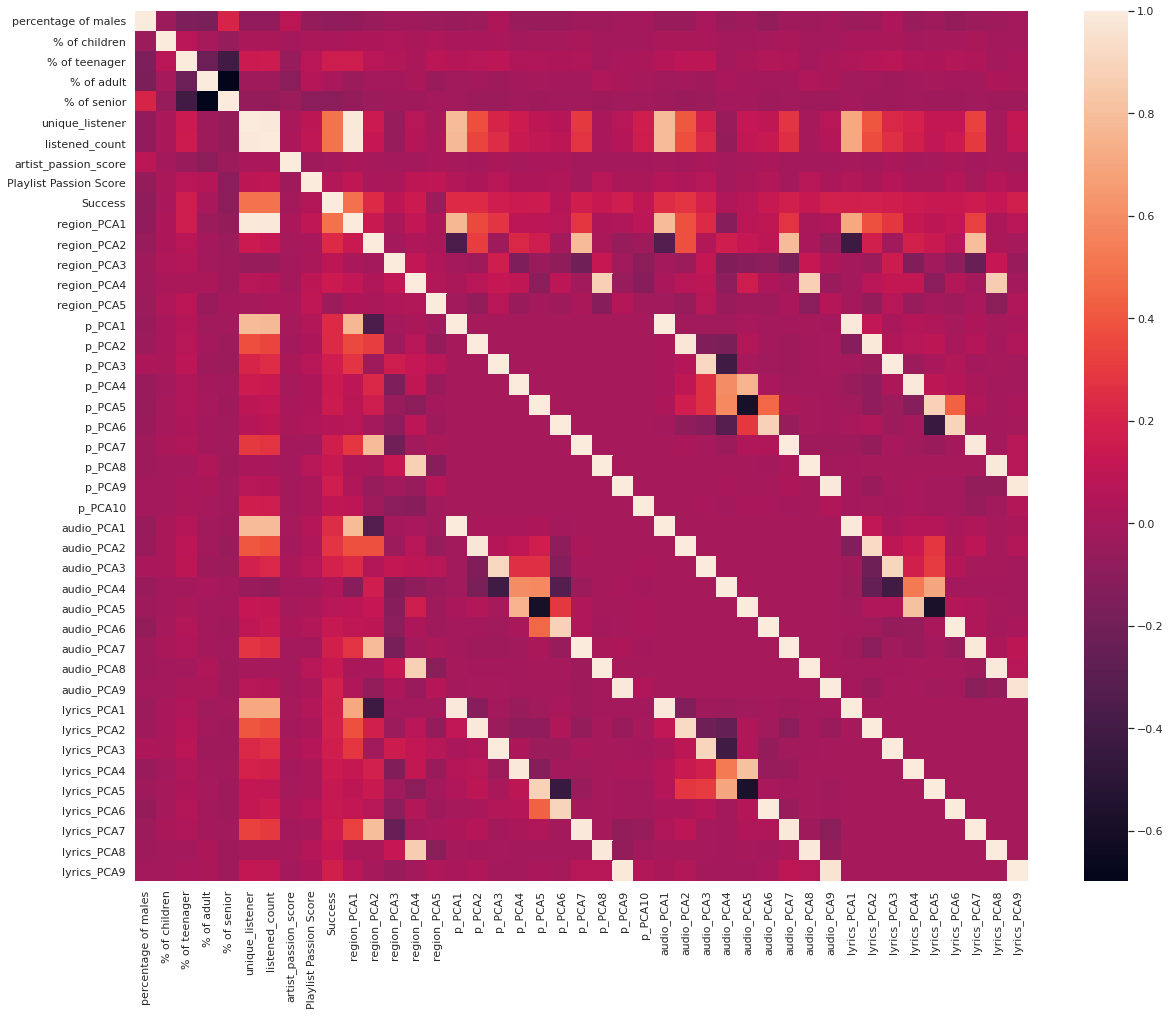

In [164]:
# Checking correlation matrix
plt.figure(figsize=(20,16))
sns.heatmap(Train.corr());

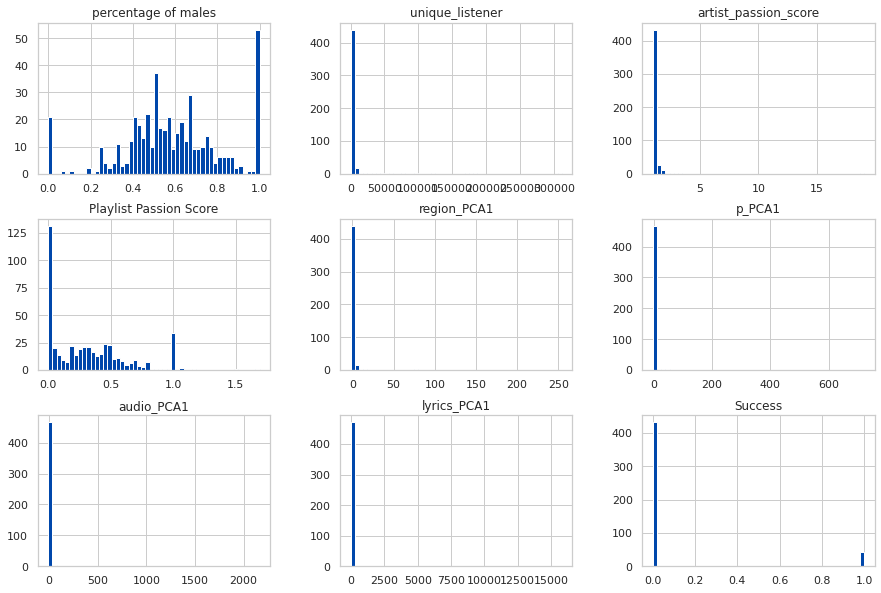

In [165]:
# Getting idea of data through train set
some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
Train[some_columns_viz].hist(bins=50, figsize=(15,10)) 
plt.show();

**Comment:** Unique listeners have a high outlier range of up to 300000.

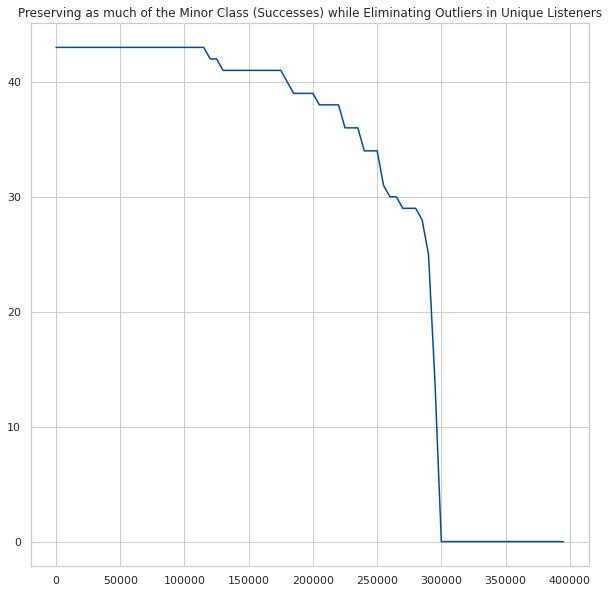

In [166]:
# How many of the minor class can we preserve removing outliers

temp1 = []
temp2 = list(range(0, 400000, 5000))
for i in temp2:
    temp3 = Train[Train.unique_listener < 300000 - i].Success.sum()
    temp1.append(temp3)
    
sns.lineplot(x=temp2, y=temp1)
plt.title('Preserving as much of the Minor Class (Successes) while Eliminating Outliers in Unique Listeners')
plt.show(); 

In [167]:
# How many of the minor class can we preserve removing outliers
Train[Train.unique_listener < 300000-230000].Success.sum()

36

In [168]:
# Number of rows lost after removing outliers
len(Train) - len(Train[Train.unique_listener < 300000-230000])

8

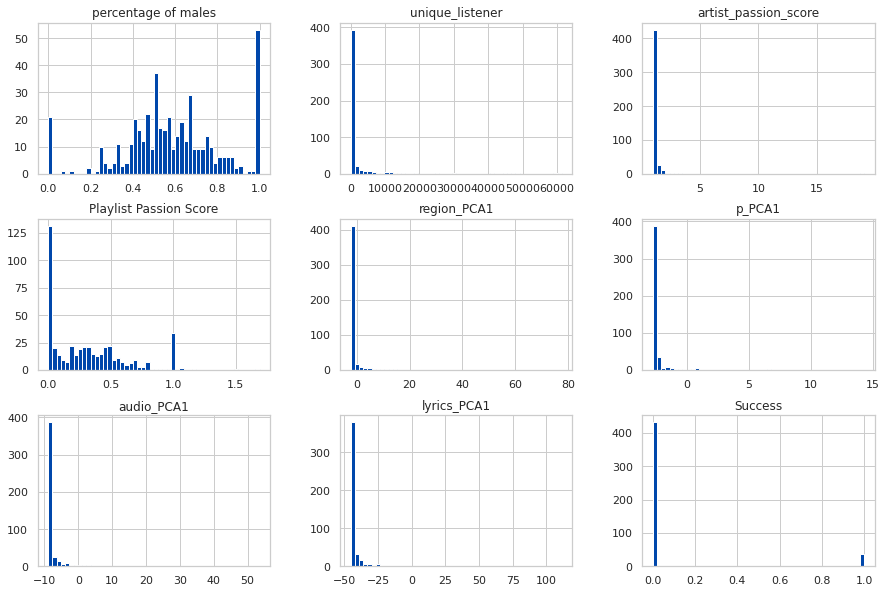

In [169]:
# Application of Outlier Removal
some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
Train[Train.unique_listener < 300000-230000][some_columns_viz].hist(bins=50, figsize=(15,10)) 
plt.show();

**Comment**: Improvements are seen across all scales, except Artist Passion Score. The outlier removal will be applied

In [170]:
# Changes made: 
p_train = p_train[p_train.unique_listener < 300000-230000]
Train = Train[Train.unique_listener < 300000-230000]

Additional data visualisations for some relationships with PCA components:

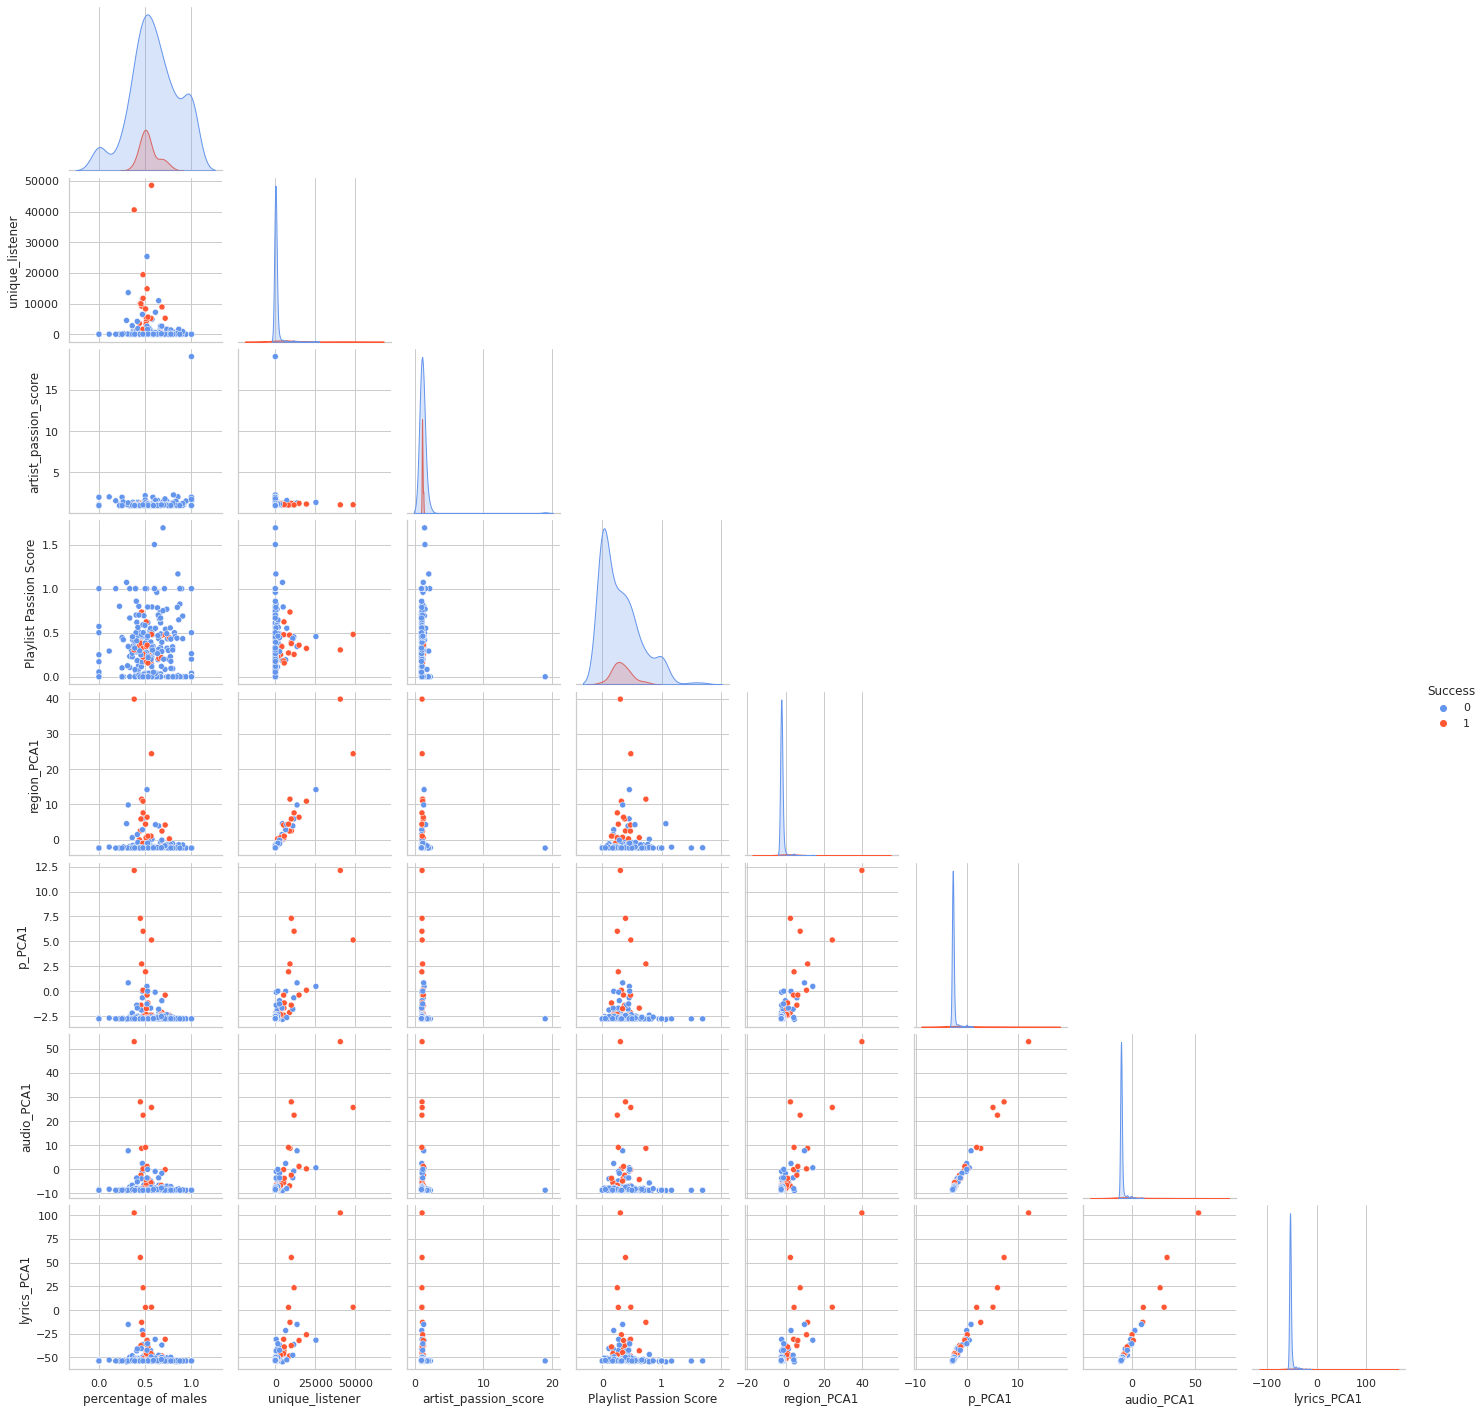

In [171]:
# Checking for polynomial terms
some_columns_viz = ['percentage of males', 'unique_listener', 'artist_passion_score', 'Playlist Passion Score', 
                    'region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 'Success']
sns.pairplot(p_train[some_columns_viz], hue='Success', corner=True, palette=['#6495ED', '#FF5733'])
plt.show(); 

Extra Data Viz between 1st and 2nd Components from the 4 PCA models - (Region, Playlist Streams, Audio Features, and Lyrics

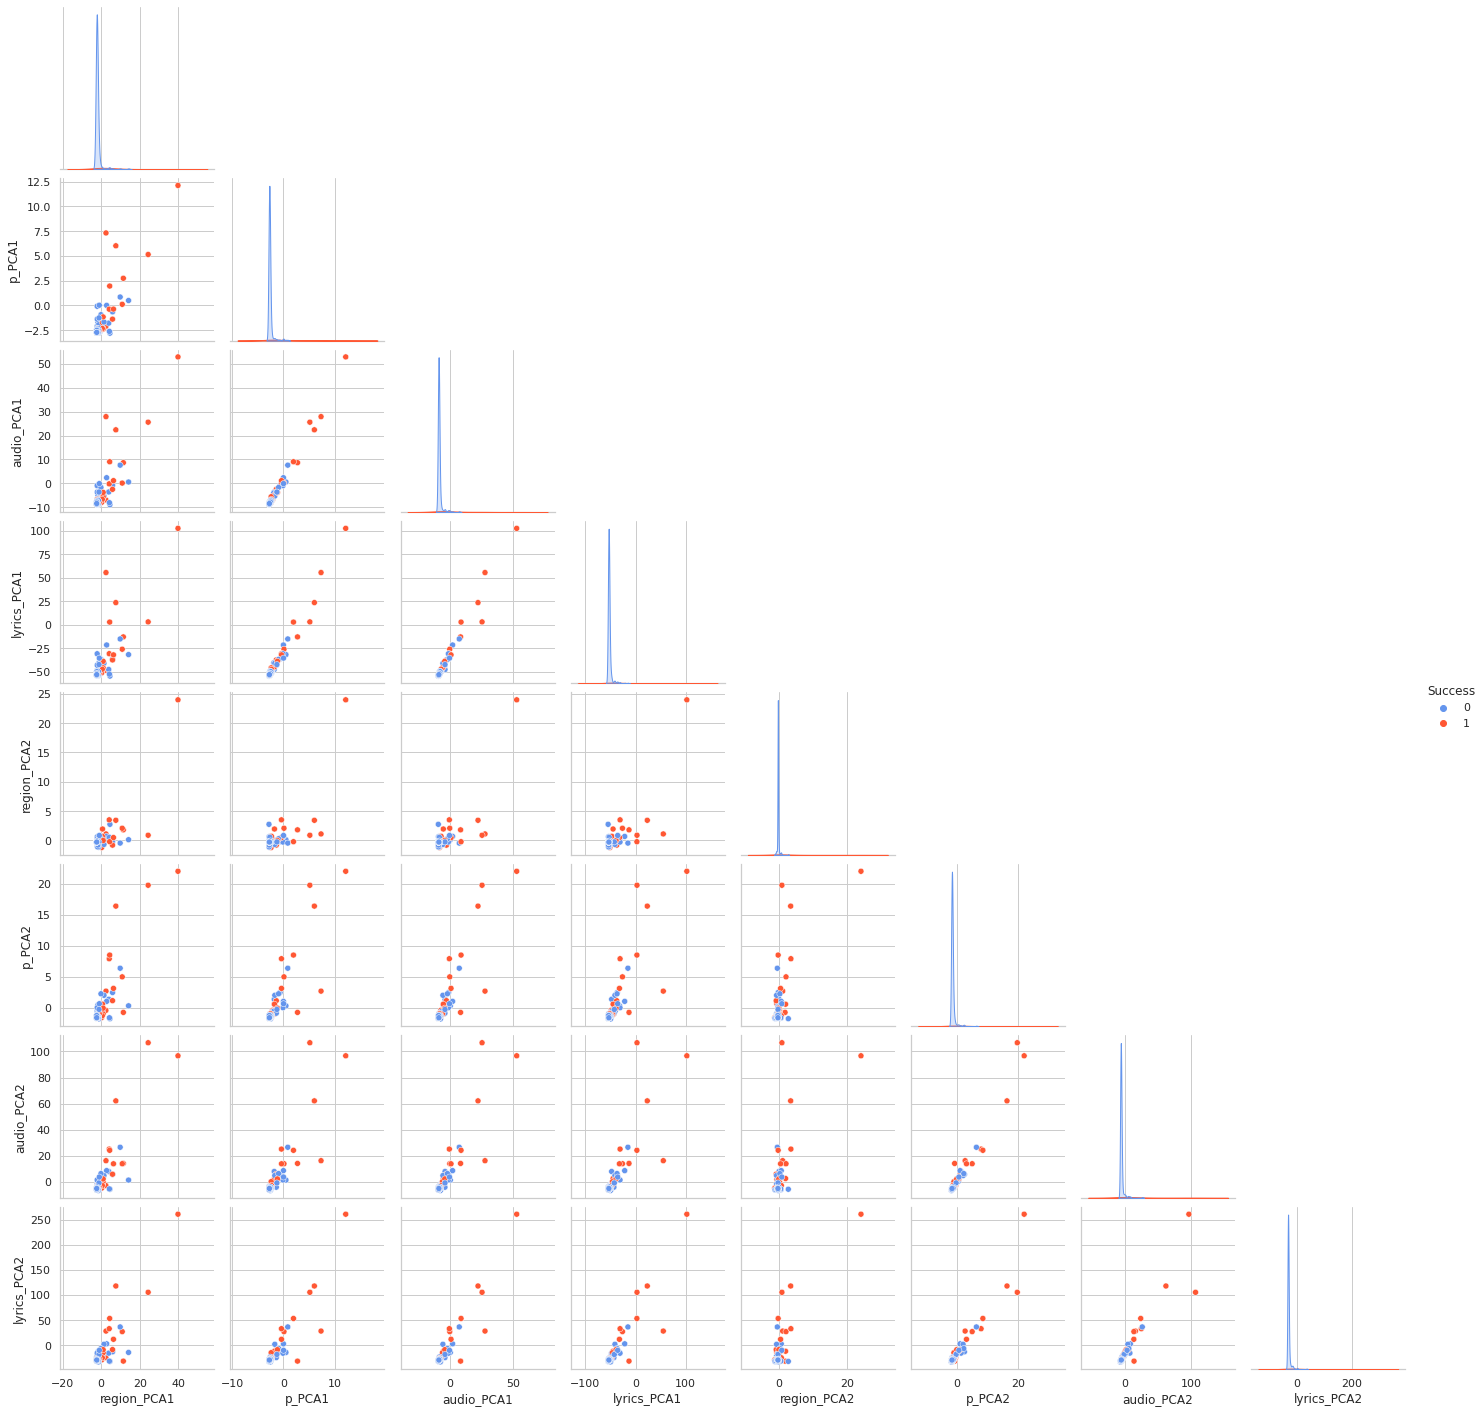

In [172]:
# Checking for PCA patterns
some_columns_viz = ['region_PCA1', 'p_PCA1', 'audio_PCA1', 'lyrics_PCA1', 
                    'region_PCA2', 'p_PCA2', 'audio_PCA2', 'lyrics_PCA2',
                    'Success']
sns.pairplot(p_train[some_columns_viz], hue='Success', corner=True, palette = ['#6495ED', '#FF5733'])
plt.show(); 

## Setting up the Models

In [173]:
# Getting the datasets ready
X_train = p_train.drop('Success', axis=1)
y_train = p_train['Success']

X_val = val.drop('Success', axis=1)
y_val = val['Success']

X_fulltrain = Train.drop('Success', axis=1)
y_fulltrain = Train['Success']

X_test = Test.drop('Success', axis=1)
y_test = Test['Success']

In [174]:
# Base Models with Default Parameters

# Setting seed
random.seed(101)
np.random.seed(101)
tf.random.set_seed(101)

# Keras basic ANN
def ann_clf():
    model=Sequential()
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy(name='accuracy'),
                           metrics.Precision(name='precision'),
                           metrics.Recall(name='recall')])
    return model

k_clf = KerasClassifier(build_fn = ann_clf, epochs=10, verbose=0)

# Models
log = Pipeline(steps=[('standardise', StandardScaler()), ('log', LogisticRegression())])
dtree = DecisionTreeClassifier(random_state=101)
rfc = RandomForestClassifier(random_state=101)
ada = AdaBoostClassifier(random_state=101)
xgb = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False, random_state=101)
svc = Pipeline(steps=[("standardise", StandardScaler()), ("svc", svm.SVC(kernel='linear'))])
ann = Pipeline(steps=[('standardise', StandardScaler()), ('ann', k_clf)])

### Shortlisting - Use: Partial Train Set and Validation Set

In [177]:
# Fitting

classifiers = [log, dtree, rfc, ada, xgb, svc, ann]
labels = ['log', 'dtree', 'rfc', 'ada', 'xgb', 'svc', 'ann']

def shortlist_models(classifiers, labels, X_train, y_train, X_val, y_val, stage):
    accuracies_train = []
    f1_scores_train = []
    recalls_train = []
    precisions_train = []
    accuracies_val = []
    f1_scores_val = []
    recalls_val = []
    precisions_val = []
    if stage == 1:
        evaluated_on = ['train']*len(labels) + ['validation']*len(labels)
    else:
        evaluated_on = ['train']*len(labels) + ['test']*len(labels)
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        pred_on_train = classifier.predict(X_train)
        pred_on_val = classifier.predict(X_val)
        
        accuracy_train = accuracy_score(y_train, pred_on_train)
        accuracy_val = accuracy_score(y_val, pred_on_val)
        f1_train = f1_score(y_train, pred_on_train)
        f1_val = f1_score(y_val, pred_on_val)
        recall_train = recall_score(y_train, pred_on_train)
        recall_val = recall_score(y_val, pred_on_val)
        precision_train = precision_score(y_train, pred_on_train)
        precision_val = precision_score(y_val, pred_on_val)
        
        accuracies_train.append(accuracy_train)
        f1_scores_train.append(f1_train)
        recalls_train.append(recall_train)
        precisions_train.append(precision_train)
        accuracies_val.append(accuracy_val)
        f1_scores_val.append(f1_val)
        recalls_val.append(recall_val)
        precisions_val.append(precision_val)
    
    temp_dict = {'model': labels*2, 'evaluated_on': evaluated_on, 'accuracy': accuracies_train+accuracies_val, 
                 'f1_score': f1_scores_train+f1_scores_val, 'recall': recalls_train+recalls_val, 
                 'precision': precisions_train+precisions_val}
        
    df = pd.DataFrame(temp_dict)
    
    return df

In [178]:
# Evaluate Models

warnings.filterwarnings('ignore')
evaluation_shortlist = shortlist_models(classifiers, labels, X_train, y_train, X_val, y_val, 1)

In [179]:
evaluation_shortlist

model evaluated_on  accuracy  f1_score    recall  precision
0     log        train  0.943463  0.578947  0.458333   0.785714
1   dtree        train  1.000000  1.000000  1.000000   1.000000
2     rfc        train  1.000000  1.000000  1.000000   1.000000
3     ada        train  1.000000  1.000000  1.000000   1.000000
4     xgb        train  1.000000  1.000000  1.000000   1.000000
5     svc        train  0.946996  0.545455  0.375000   1.000000
6     ann        train  0.929329  0.411765  0.291667   0.700000
7     log   validation  0.931579  0.580645  0.500000   0.692308
8   dtree   validation  0.857895  0.341463  0.388889   0.304348
9     rfc   validation  0.947368  0.722222  0.722222   0.722222
10    ada   validation  0.900000  0.577778  0.722222   0.481481
11    xgb   validation  0.889474  0.432432  0.444444   0.421053
12    svc   validation  0.878947  0.148148  0.111111   0.222222
13    ann   validation  0.910526  0.260870  0.166667   0.600000

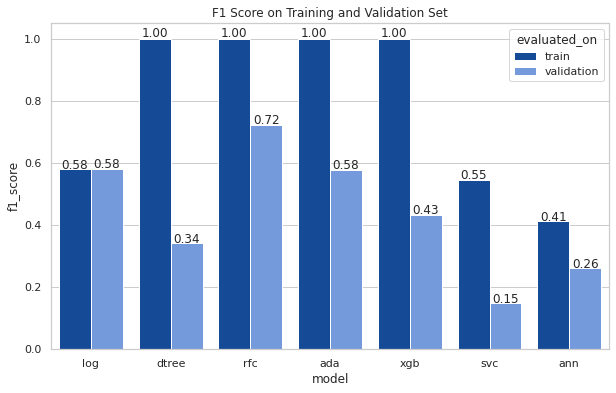

In [180]:
# Visualising results
plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='f1_score', hue='evaluated_on', data=evaluation_shortlist)
plt.title('F1 Score on Training and Validation Set')
show_values(g)
plt.show();

**Comment**: Random Forest has the highest f1-score on the validation set, given having maximum performance on training set. It does indicate overfitting, however. Neural networks perform the 2nd best on validation, but its performance on training set is the lowest, and implies it is by chance. Hence, we will go through with just hypertuning Random Forest.

## Feature Selection
### Feature Importance

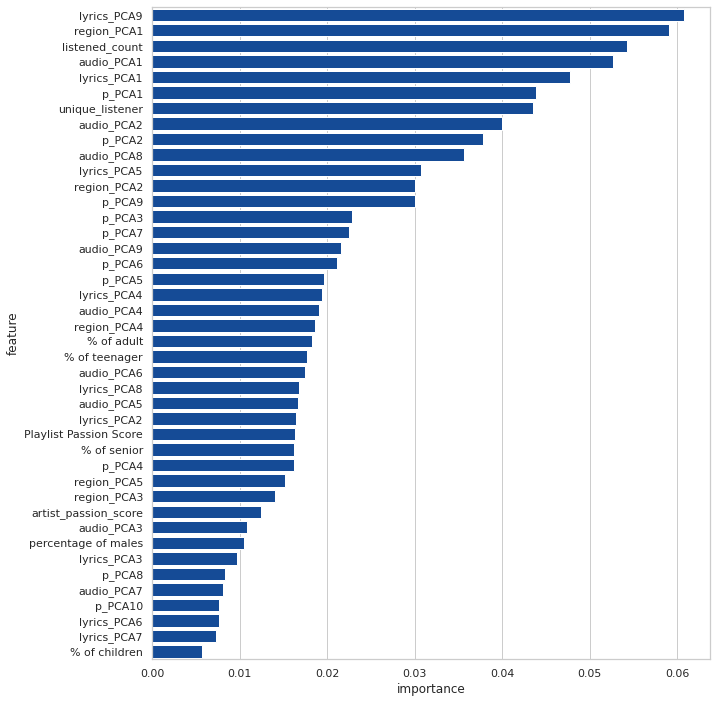

In [181]:
#  Feature Importances from Random Forest
temp_x = X_train.columns.tolist()
temp_y = rfc.feature_importances_
temp_df = pd.DataFrame({'feature': temp_x, 'importance': temp_y})
temp_df.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(10,12))
sns.barplot(x='importance', y='feature', data=temp_df, color='#0047AB')
plt.show();

In [182]:
# Checking the lowest ones between both tree-based models
least_important_rfc = temp_df[temp_df.importance < 0.03].feature.tolist()
eliminate_features1 = least_important_rfc
eliminate_features1

['p_PCA3',
 'p_PCA7',
 'audio_PCA9',
 'p_PCA6',
 'p_PCA5',
 'lyrics_PCA4',
 'audio_PCA4',
 'region_PCA4',
 '% of adult',
 '% of teenager',
 'audio_PCA6',
 'lyrics_PCA8',
 'audio_PCA5',
 'lyrics_PCA2',
 'Playlist Passion Score',
 '% of senior',
 'p_PCA4',
 'region_PCA5',
 'region_PCA3',
 'artist_passion_score',
 'audio_PCA3',
 'percentage of males',
 'lyrics_PCA3',
 'p_PCA8',
 'audio_PCA7',
 'p_PCA10',
 'lyrics_PCA6',
 'lyrics_PCA7',
 '% of children']

###  Anova and Lasso

In [183]:
# Import the necessary libraries first
feature_names = X_train.columns

In [184]:
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X_train, y_train)
anova_selected_features = feature_names[selector.get_support()]

In [185]:
## Lasso regularization

selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X_train, y_train)
lasso_selected_features = feature_names[selector.get_support()]

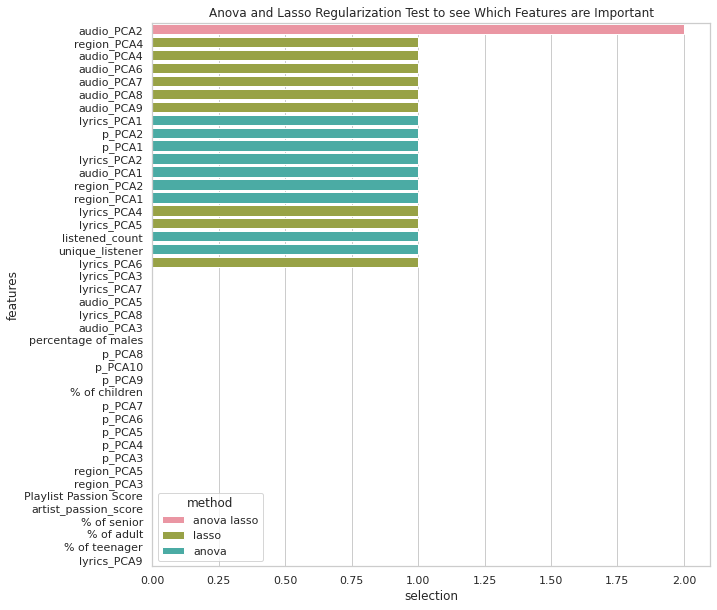

In [186]:
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(10,10))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)
plt.title('Anova and Lasso Regularization Test to see Which Features are Important')
plt.show();

In [187]:
least_important_ANOVA_Lasso = dtf_features[dtf_features.selection==0].features.tolist()
eliminate_features2 = list(set(least_important_ANOVA_Lasso).intersection(eliminate_features1))
final_eliminate = eliminate_features2
final_eliminate

['artist_passion_score',
 '% of children',
 'p_PCA5',
 'p_PCA4',
 'region_PCA3',
 '% of senior',
 'audio_PCA5',
 'lyrics_PCA8',
 '% of adult',
 'p_PCA6',
 'p_PCA7',
 'lyrics_PCA7',
 'percentage of males',
 'p_PCA8',
 'Playlist Passion Score',
 'region_PCA5',
 'lyrics_PCA3',
 'p_PCA10',
 '% of teenager',
 'audio_PCA3',
 'p_PCA3']

In [188]:
len(final_eliminate)

21

**Comment:** 22 features will be dropped. These results are consistent between Random Forest and Lasso and ANOVA.

In [189]:
# Drop the columns
X_train.drop(final_eliminate, axis=1, inplace=True)
X_val.drop(final_eliminate, axis=1, inplace=True)
X_fulltrain.drop(final_eliminate, axis=1, inplace=True)
X_test.drop(final_eliminate, axis=1, inplace=True)

In [190]:
# Total number of features now
len(X_train.columns)

21

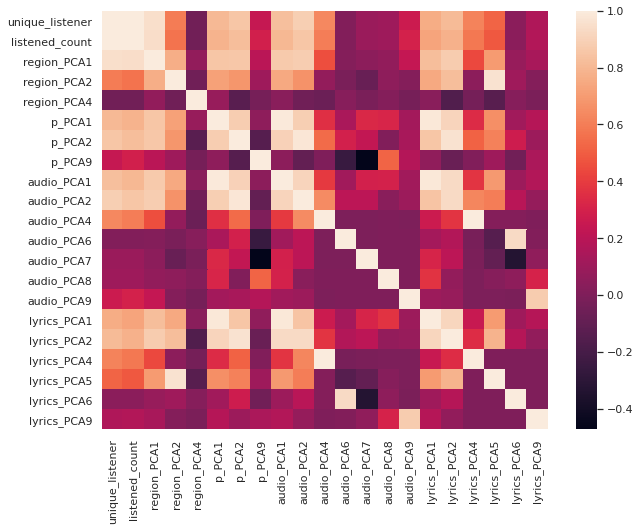

In [191]:
# Correlation matrix among remaining columns
plt.figure(figsize=(10,7.7))
sns.heatmap(X_train.corr())
plt.show();

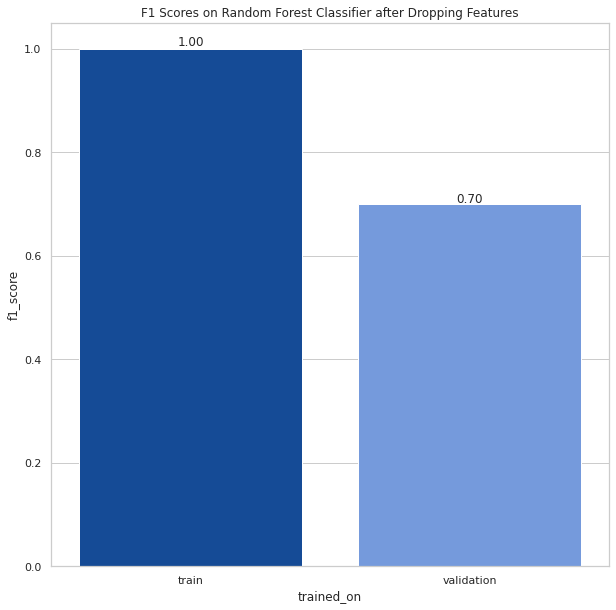

In [192]:
# Checking performance of new rfc
rfc = RandomForestClassifier(random_state=101)
rfc.fit(X_train, y_train)
pred_on_val = rfc.predict(X_val).tolist()
pred_on_train = rfc.predict(X_train).tolist()
val_f1_score = f1_score(y_val, pred_on_val)
train_f1_score = f1_score(y_train, pred_on_train)
f1_scores = [train_f1_score, val_f1_score]
labels = ['train', 'validation']
temp_df = pd.DataFrame({'trained_on':labels, 'f1_score': f1_scores})
g = sns.barplot(x='trained_on', y='f1_score', data=temp_df)
plt.title('F1 Scores on Random Forest Classifier after Dropping Features')
show_values(g)
plt.show();

# Hyperparameter Turning

In [193]:
# DO NOT RUN FROM HERE. SKIP TO GRID SEARCH RESULTS
# MANDATORY STOPPER

In [194]:
# Processing for GridSearch on Validation Set

X_train_val_comb = pd.concat([X_train.copy(), X_val.copy()])
y_train_val_comb = pd.concat([y_train.copy(), y_val.copy()])

In [195]:
# Comparing against train set

X_train_train_comb = pd.concat([X_train.copy(), X_train.copy()])
y_train_train_comb = pd.concat([y_train.copy(), y_train.copy()])

In [196]:
# Evaluating on validation set

split_index = [-1]*len(X_train) + [0]*len(X_val)
pds = PredefinedSplit(test_fold = split_index)

In [197]:
# evaluating on train set

split_index2 = [-1]*len(X_train) + [0]*len(X_train)
pds2 = PredefinedSplit(test_fold = split_index2)

In [198]:
# Redefining the shortlisted models

rfc = RandomForestClassifier(criterion = 'gini', random_state=101, n_jobs=-1)

In [199]:
# Setting params

param_grid_rfc = {
    "n_estimators": [30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300], 
    "max_depth": [30, 40, 50, 70, 80],
    "min_samples_leaf": [1, 2, 3], 
    "min_samples_split": [2, 3], 
} #  combinations


In [200]:
# Defining Grid Search 

# Scoring
scoring = ['recall', 'precision', 'f1', 'accuracy']

gs_rfc = GridSearchCV(rfc, param_grid_rfc, cv = pds, scoring=scoring, refit=False, n_jobs=-1)

In [201]:
# Fitting random forest

gs_rfc.fit(X_train_val_comb, y_train_val_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [30, 40, 50, 70, 80],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100, 120,
                                          150, 200, 250, 300]},
             refit=False, scoring=['recall', 'precision', 'f1', 'accuracy'])

In [202]:
# Determining columns of interest

metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']

rfc_params_columns = ['param_max_depth', 'param_min_samples_leaf', 
                      'param_min_samples_split', 'param_n_estimators'] + metrics_of_interest


# Grid Search

In [203]:
# assigning results to variables, and saving them

# Assigning dataframes to variables
rfc_grid_results = pd.DataFrame(gs_rfc.cv_results_).sort_values(by='mean_test_f1', ascending=False)[rfc_params_columns]

# Saving
rfc_grid_results.to_csv('./gridsearch_results/rfc_grid_results.csv', index=False)

In [204]:
# Load

rfc_grid_results = pd.read_csv('./gridsearch_results/rfc_grid_results.csv')

Note: Multiple parameter combinations have the same scores across the different metrics. We will optimise on efficiency by choosing the one with the lowest fit amongst the best scoring ones.

In [205]:
# Checking random forest scores

rfc_grid_highest = rfc_grid_results[rfc_grid_results.mean_test_f1 == rfc_grid_results.mean_test_f1.max()]
rfc_grid_highest.head(1) 

param_max_depth  param_min_samples_leaf  param_min_samples_split  \
0               50                       2                        3   

   param_n_estimators  mean_test_f1  mean_test_recall  mean_test_precision  \
0                  30      0.756757          0.777778             0.736842   

   mean_test_accuracy  mean_fit_time  
0            0.952632       0.143192

# Visualisaing Grid Search Results

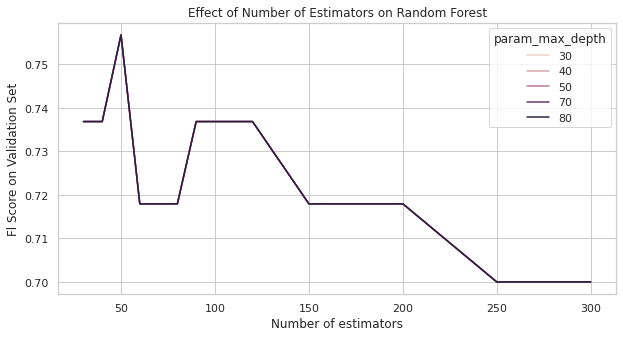

In [206]:
# Random Forest F1 with Gini and Min_sample_leaf==4, split=5, etc

plt.figure(figsize=(10,5))
sns.lineplot(y='mean_test_f1', x='param_n_estimators', 
             data=rfc_grid_results[(rfc_grid_results.param_min_samples_split == 3) & 
                                   (rfc_grid_results.param_min_samples_leaf == 3)], hue='param_max_depth')
plt.title('Effect of Number of Estimators on Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Fl Score on Validation Set')
plt.show();

**Comment**: It seems that max depth has very little effect, as all the different max depths follow the same line

In [207]:
# Checking performance on train set as well
rfc_t = RandomForestClassifier(criterion='gini', random_state=101, n_jobs=-1)
gs_rfc_t = GridSearchCV(rfc_t, param_grid_rfc, cv = pds2, scoring=scoring, refit=False, n_jobs=-1)
gs_rfc_t.fit(X_train_train_comb, y_train_train_comb)
rfc_t_grid_results = pd.DataFrame(gs_rfc_t.cv_results_).sort_values(by='mean_test_f1', ascending=False)[rfc_params_columns]

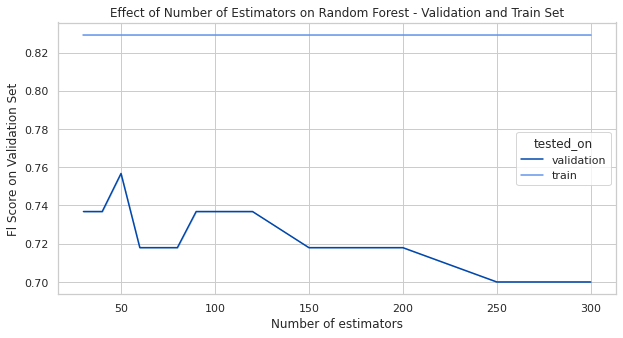

In [208]:
# Visualising val and train

rfc_vt = pd.concat([rfc_grid_results.copy(), rfc_t_grid_results.copy()])
rfc_vt['tested_on'] = ['validation']*len(rfc_grid_results) + ['train']*len(rfc_t_grid_results)

# Visualise
plt.figure(figsize=(10,5))
sns.lineplot(y='mean_test_f1', x='param_n_estimators', 
             data=rfc_vt[(rfc_vt.param_min_samples_split == 3) & 
                         (rfc_vt.param_min_samples_leaf == 3)], hue='tested_on')
plt.title('Effect of Number of Estimators on Random Forest - Validation and Train Set')
plt.xlabel('Number of estimators')
plt.ylabel('Fl Score on Validation Set')
plt.show();

**Comment**: Lower number of estimators is preferred, particularly 50 and 70. Beyond 100 estimators expresses evident overfitting, and below 50 demonstrates an area of underfitting. While we use there hyperparameters, the f1 scores are not close to convergence, and variability is expected.

# Exploring Undersampling and SMOTE

In [209]:
# Reconfirming ratio of minority over overall dataset

round(y_fulltrain.sum()/len(y_fulltrain),2)

0.08

### Undersampling
We will look to ___ for inspiration to test out different undersampling strategies. We will user RandomUnderSampler from the imblearn library.m

In [210]:
# Redefining models with updated parameters


rfc_v = Pipeline(steps=[('under', RandomUnderSampler()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[('under', RandomUnderSampler()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])

In [211]:
# Params to explore

param_under_sampling = {
    'under__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.6]
}

In [212]:
# Redefining Scoring
scoring = ['recall', 'precision', 'f1', 'accuracy']

In [213]:
# Undersampling grid search
# grid_search_log_undersampling = GridSearchCV(log, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_undersampling = GridSearchCV(dtree, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_undersampling = GridSearchCV(rfc_v, param_under_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_undersampling = GridSearchCV(rfc_t, param_under_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [214]:
# Fitting 
# grid_search_log_undersampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_undersampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_undersampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_undersampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('under', RandomUnderSampler()),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'under__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.6]},
             refit=False, scoring=['recall', 'precision', 'f1', 'accuracy'])

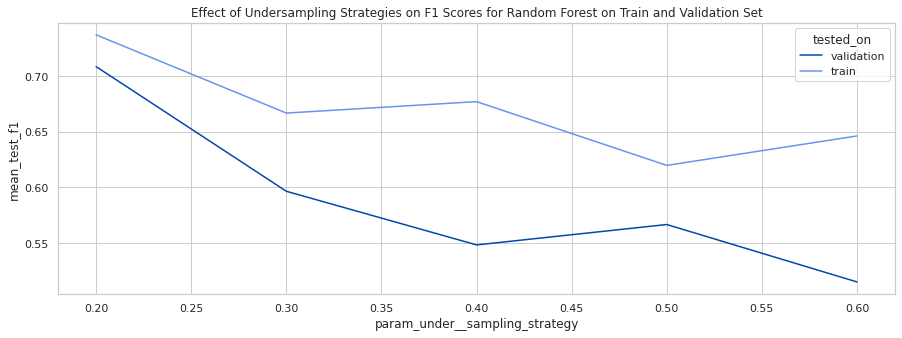

In [215]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
undersamplings_metrics = ['param_under__sampling_strategy'] + metrics_of_interest

# Extracting the data from grid searches
# gslus = pd.DataFrame(grid_search_log_undersampling.cv_results_)[undersamplings_metrics] # gridsearch log undersampling - gslus
# gsdus = pd.DataFrame(grid_search_dtree_undersampling.cv_results_)[undersamplings_metrics] # gridsearch dtree undersampling - gsdus
gsrus_v = pd.DataFrame(grid_search_rfc_v_undersampling.cv_results_)[undersamplings_metrics] # gridsearch rfc undersampling - gsrus_v
gsrus_t = pd.DataFrame(grid_search_rfc_t_undersampling.cv_results_)[undersamplings_metrics] # gridsearch rfc undersampling - gsrus_t

# Creating extra columns with model name
# gslus['model'] = 'log'
# gsdus['model'] = 'dtree'
# gsrus['model'] = 'rfc'
# gsrus['tested_on'] = ['validation']*len(gsrus_v) + ['train']*len(gsrus_t)

# concatenate
grid_undersampling_results = pd.concat([gsrus_v, gsrus_t])
grid_undersampling_results['tested_on'] = ['validation']*len(gsrus_v) + ['train']*len(gsrus_t)

plt.figure(figsize=(15,5))
sns.lineplot(data=grid_undersampling_results, x='param_under__sampling_strategy', y='mean_test_f1', hue='tested_on')
plt.title('Effect of Undersampling Strategies on F1 Scores for Random Forest on Train and Validation Set')
plt.show()

**Comment**: Undersampling actually makes the F1 score worse, which is surprising, as it reduces the majority class. It perhaps removes important boundaries, and hence, loss of information. However, at a sampling strategy of 0.2, train and validation performance converges, which would suggest true performance is closer and predictive capability is reliable. We will test the sampling strategy of 0.2 on the final test set.

### Oversampling - SMOTE Method

In [216]:
# Redefining models with updated parameters

rfc_v = Pipeline(steps=[('over', SMOTE()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[('over', SMOTE()),  
                      ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                                     min_samples_split=3, max_depth =50, n_estimators=70, 
                                                     random_state=101, n_jobs=-1))])


In [217]:
# Params to explore

param_over_sampling = {
    'over__sampling_strategy': [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
} 

In [218]:
# Undersampling grid search

# grid_search_log_oversampling = GridSearchCV(log, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_oversampling = GridSearchCV(dtree, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_oversampling = GridSearchCV(rfc_v, param_over_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_oversampling = GridSearchCV(rfc_t, param_over_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [219]:
# Fitting 

# grid_search_log_oversampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_oversampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_oversampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_oversampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'over__sampling_strategy': [0.15, 0.2, 0.25, 0.3, 0.35,
                                                     0.4, 0.45, 0.5, 0.55,
                                                     0.6]},
             refit=False, scoring=['recall', 'precision', 'f1', '

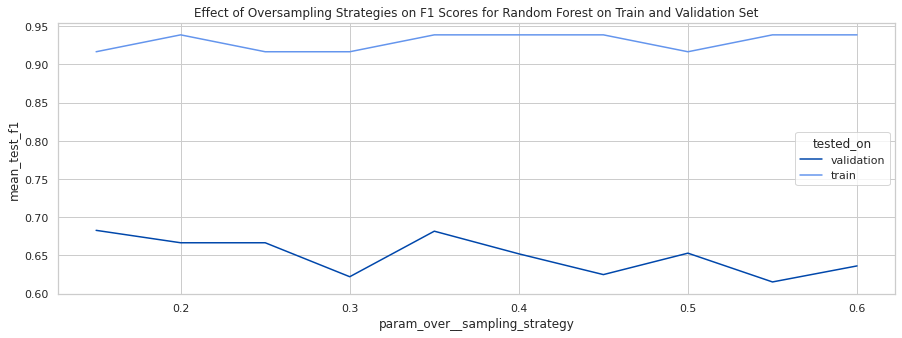

In [220]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
oversamplings_metrics = ['param_over__sampling_strategy'] + metrics_of_interest

# # Extracting the data from grid searches
# gslos = pd.DataFrame(grid_search_log_oversampling.cv_results_)[oversamplings_metrics] # gridsearch log oversampling - gslos
# gsdos = pd.DataFrame(grid_search_dtree_oversampling.cv_results_)[oversamplings_metrics] # gridsearch dtree oversampling - gsdos
# gsros = pd.DataFrame(grid_search_rfc_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc oversampling - gsros

# # Creating extra columns with model name
# gslos['model'] = 'log'
# gsdos['model'] = 'dtree'
# gsros['model'] = 'rfc'

# # concatenate
# grid_oversampling_results = pd.concat([gslos, gsdos, gsros])

# plt.figure(figsize=(15,5))
# sns.lineplot(data=grid_oversampling_results, x='param_over__sampling_strategy', y='mean_test_f1', hue='model')
# plt.title('Effect of Overampling Strategies on F1 Scores for Different Models')
# plt.show()

gsros_v = pd.DataFrame(grid_search_rfc_v_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc undersampling - gsrus_v
gsros_t = pd.DataFrame(grid_search_rfc_t_oversampling.cv_results_)[oversamplings_metrics] # gridsearch rfc undersampling - gsrus_t

# concatenate
grid_oversampling_results = pd.concat([gsros_v, gsros_t])
grid_oversampling_results['tested_on'] = ['validation']*len(gsros_v) + ['train']*len(gsros_t)

plt.figure(figsize=(15,5))
sns.lineplot(data=grid_oversampling_results, x='param_over__sampling_strategy', y='mean_test_f1', hue='tested_on')
plt.title('Effect of Oversampling Strategies on F1 Scores for Random Forest on Train and Validation Set')
plt.show()

**Comment**: SMOTE causes our model to overfit drastically, as seen in the improvement on just the train, but the decrease in performance in the validation set. The highest as at 0.1, which is almost similar to no oversampling applied. We won't be exploring any model from here. We see no converge, and no parameter is attractive. We will now look to the paper by Chawla et al. (2002) to take on their advice of combining undersampling with oversampling.

### Combinaton

In [221]:
# Redefining models with updated parameters

# log = Pipeline(steps=[('under', NearMiss()), 
#                       ('over', SMOTE(random_state=101)),
#                       ('standardise', StandardScaler()), 
#                       ('log', LogisticRegression(C=1.1, penalty='l2', solver='sag'))])

# dtree = Pipeline(steps=[('under', NearMiss()), 
#                         ('over', SMOTE(random_state=101)),
#                         ('dtree', DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=1, 
#                                                          min_samples_split=5, max_depth=3, random_state=101))])

rfc_v = Pipeline(steps=[
    ('under', RandomUnderSampler(random_state=101)), 
    ('over', SMOTE(random_state=101)),
    ('rfc', RandomForestClassifier(criterion='gini', 
                                   min_samples_leaf=3,
                                   min_samples_split=3, max_depth =50, n_estimators=70, 
                                   random_state=101, n_jobs=-1))])

rfc_t = Pipeline(steps=[
    ('under', RandomUnderSampler(random_state=101)), 
    ('over', SMOTE(random_state=101)),
    ('rfc', RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                   min_samples_split=3, max_depth =50, n_estimators=70, 
                                   random_state=101, n_jobs=-1))])

In [222]:
# Params to explore

param_sampling = {
    'under__sampling_strategy': [0.15, 0.175, 0.2], 
    'over__sampling_strategy': [0.225, 0.25, 0.275] 
} # 

In [223]:
# Redefining Scoring

scoring = ['recall', 'precision', 'f1', 'accuracy']

In [224]:
# Sampling grid search

# grid_search_log_sampling = GridSearchCV(log, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
# grid_search_dtree_sampling = GridSearchCV(dtree, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_v_sampling = GridSearchCV(rfc_v, param_sampling, cv=pds, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)
grid_search_rfc_t_sampling = GridSearchCV(rfc_t, param_sampling, cv=pds2, n_jobs=-1, scoring=scoring, error_score='raise', refit=False)

In [225]:
# Fitting 

# grid_search_log_sampling.fit(X_train_val_comb, y_train_val_comb)
# grid_search_dtree_sampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_v_sampling.fit(X_train_val_comb, y_train_val_comb)
grid_search_rfc_t_sampling.fit(X_train_train_comb, y_train_train_comb)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=101)),
                                       ('over', SMOTE(random_state=101)),
                                       ('rfc',
                                        RandomForestClassifier(max_depth=50,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=70,
                                                               n_jobs=-1,
                                                               random_state=101))]),
             n_jobs=-1,
             param_grid={'over__sampling_strategy': [0.225, 0.25, 0.275],
                         'under__sampling_strategy': [0.15, 0.1

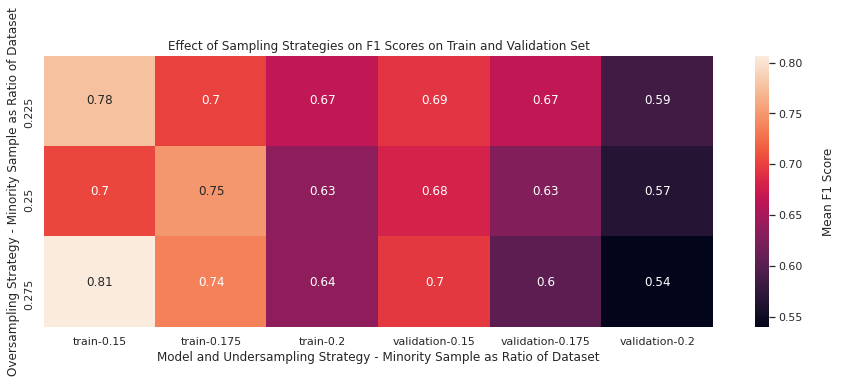

In [226]:
# Concatenating and saving

# Metrics of interest
metrics_of_interest = ['mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy', 'mean_fit_time']
samplings_metrics = ['param_over__sampling_strategy', 'param_under__sampling_strategy'] + metrics_of_interest

# Extracting the data from grid searches
# gsls = pd.DataFrame(grid_search_log_sampling.cv_results_)[samplings_metrics] # gridsearch log sampling - gsls
# gsds = pd.DataFrame(grid_search_dtree_sampling.cv_results_)[samplings_metrics] # gridsearch dtree sampling - gsds
gsrs_v = pd.DataFrame(grid_search_rfc_v_sampling.cv_results_)[samplings_metrics] # gridsearch rfc sampling - gsrs
gsrs_t = pd.DataFrame(grid_search_rfc_t_sampling.cv_results_)[samplings_metrics]

# Creating extra columns with model name
# gsls['model'] = 'log'
# gsds['model'] = 'dtree'
# gsrs['model'] = 'rfc'
gsrs_v['trained_on'] = 'validation'
gsrs_t['trained_on'] = 'train'

# concatenate
# grid_sampling_results = pd.concat([gsls, gsds, gsrs])
grid_sampling_results = pd.concat([gsrs_v, gsrs_t])

# reorganise
sampling_f1 = pd.pivot_table(grid_sampling_results, values='mean_test_f1',
                             index='param_over__sampling_strategy', 
                             columns = ['trained_on', 'param_under__sampling_strategy'],
                             aggfunc=np.mean)

plt.figure(figsize=(15,5))
sns.heatmap(sampling_f1, annot=True, cbar_kws={'label': '\nMean F1 Score'})
plt.xlabel('Model and Undersampling Strategy - Minority Sample as Ratio of Dataset')
plt.ylabel('Oversampling Strategy - Minority Sample as Ratio of Dataset')
plt.title('Effect of Sampling Strategies on F1 Scores on Train and Validation Set')
plt.show()

**Comment**: None of the combinations have surpassed F1 score on the validation set from the hyperparameter tuning stage. However, one combination of parameters from under and oversampling have produced results very close to one another between train and validation sets. They are the upper left blocks of both the train and validation sets - 71% validation score. This can be determined from the blocks with closely similar colors in the left and right side of the heatmap.

# Full Train and Test
We are interested in 4 Random Forest Classifier Models to test on the test set:

1. Default parameters
2. Hyperparameter tuned
3. Undersampling
4. Combination of undersampling and oversampling

In [227]:
# Defining models

# d --> default
rfc_d = RandomForestClassifier(random_state=101) 

# ht --> hyperparameter tuned
rfc_ht = RandomForestClassifier(criterion='gini', 
                                min_samples_leaf=3,
                                min_samples_split=3, 
                                max_depth = 50, 
                                n_estimators=70, 
                                random_state=101, 
                                n_jobs=-1)


# c --> combination of sampling strategies
rfc_c = Pipeline(steps=[('under', RandomUnderSampler(random_state=101, sampling_strategy=0.15)), 
                        ('over', SMOTE(random_state=101, sampling_strategy=0.225)),
                        ('rfc', RandomForestClassifier(criterion='gini', 
                                                       min_samples_leaf=3,
                                                       min_samples_split=3, 
                                                       max_depth =50, 
                                                       n_estimators=70, 
                                                       random_state=101, 
                                                       n_jobs=-1))])

models = [rfc_d, rfc_ht, rfc_c]
labels = ['default', 'hyperparameter_tuned', 'sampling_combination']

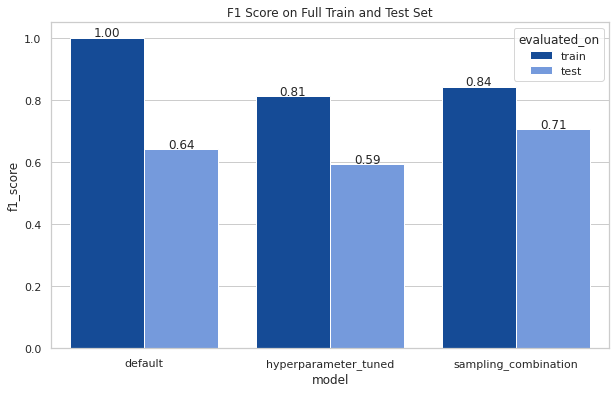

In [228]:
see_results_train_test = shortlist_models(models, labels, X_fulltrain, y_fulltrain, X_test, y_test, 2)

# Visualising results

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='f1_score', hue='evaluated_on', data=see_results_train_test)
plt.title('F1 Score on Full Train and Test Set')
show_values(g)
plt.show();

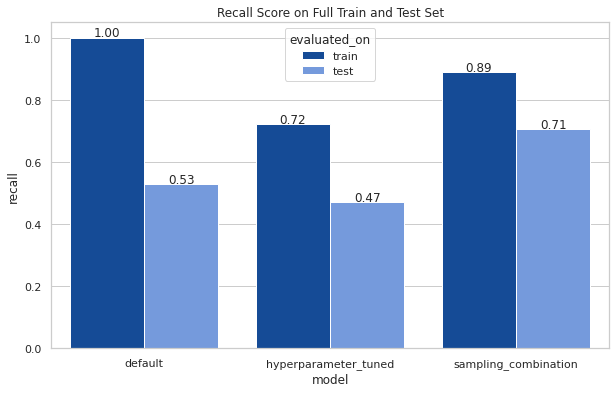

In [229]:
# Recall

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='recall', hue='evaluated_on', data=see_results_train_test)
plt.title('Recall Score on Full Train and Test Set')
show_values(g)
plt.show();

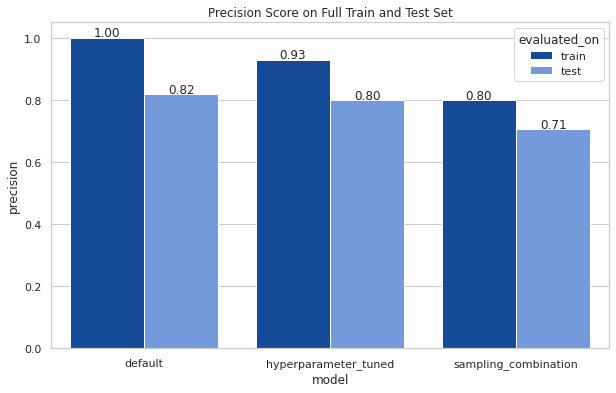

In [230]:
# Precision

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='precision', hue='evaluated_on', data=see_results_train_test)
plt.title('Precision Score on Full Train and Test Set')
show_values(g)
plt.show();

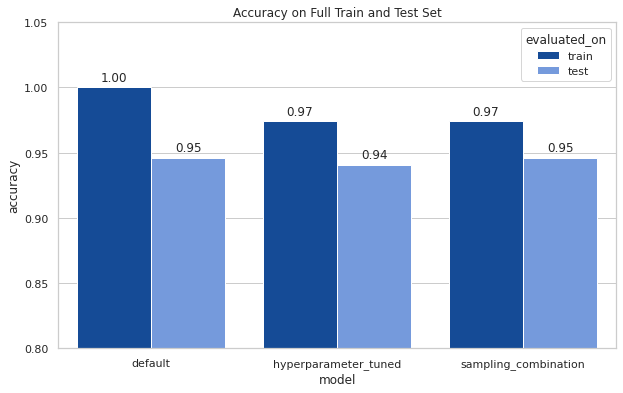

In [231]:
# Accuracy

plt.figure(figsize=(10,6))
g = sns.barplot(x='model', y='accuracy', hue='evaluated_on', data=see_results_train_test)
plt.title('Accuracy on Full Train and Test Set')
show_values(g)
plt.ylim(0.8, 1.05)
plt.show();

**Comment**: The Random Forest Classifier with sampling combination has a higher F1_score, which has the same value for both precision and recall. It is able to detect successes with a higher recall and precision, which is what we are looking for. Additionally, this is the model we will use to discern what contributes to the success.m

In [232]:
rfc_c[2].feature_importances_

array([0.09502639, 0.07536581, 0.10659185, 0.04047422, 0.02433106,
       0.10598731, 0.00649444, 0.01806813, 0.05525418, 0.0294217 ,
       0.01194196, 0.02736585, 0.12691361, 0.0066518 , 0.0458162 ,
       0.07990599, 0.03861306, 0.03818252, 0.01737752, 0.01326124,
       0.03695516])

In [233]:
pk.dump(rfc_c, open('./Final_Model/Final_RandomForestClassifier.pkl', 'wb'))

# Dissecting Chosen Model - Random Forest Classifier

In [234]:
# Defining function to visualise 

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.005)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# Zach (2021). 

In [235]:
# Loading the datasets

# Loading
Train = pd.read_csv('./Train_Validation_Test/TRUE_TRAIN.csv')
Test = pd.read_csv('./Train_Validation_Test/TRUE_TEST.csv')

# Drop artist column
Train.drop('artist_name', axis=1, inplace=True)
Test.drop('artist_name', axis=1, inplace=True)

# Prepping
X_fulltrain = Train.drop('Success', axis=1)
y_fulltrain = Train['Success']
X_test = Test.drop('Success', axis=1)
y_test = Test['Success']

# Dropping unnecessary columns (from feature selection in B)


X_fulltrain.drop(final_eliminate, axis=1, inplace=True)
X_test.drop(final_eliminate, axis=1, inplace=True)

In [236]:
# Open model
chosen_rfc = pk.load(open('./Final_Model/Final_RandomForestClassifier.pkl', 'rb'))

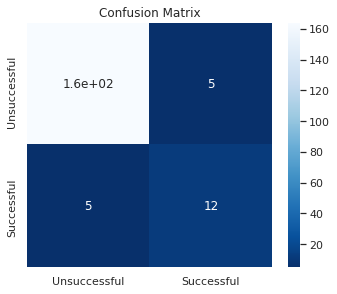

In [237]:
# Checking confusion matrix
rfc_cm = confusion_matrix(y_test, chosen_rfc.predict(X_test))

plt.figure(figsize=(5.5,4.5))
sns.heatmap(rfc_cm, annot=True, cmap='Blues_r')
plt.xticks([0.5,1.5], ['Unsuccessful', 'Successful'])
plt.yticks([0.3,1.3], ['Unsuccessful', 'Successful'])
plt.title('Confusion Matrix')
# plt.show();
plt.savefig('./Model_Evaluation_Images/Confusion_Matrix.png')

In [238]:
# Classification report

print(classification_report(y_test, chosen_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       169
           1       0.71      0.71      0.71        17

    accuracy                           0.95       186
   macro avg       0.84      0.84      0.84       186
weighted avg       0.95      0.95      0.95       186



Text(0.5, 1.0, 'Feature Importance')

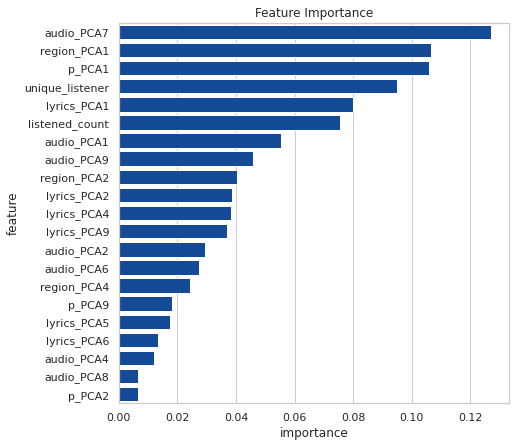

In [239]:
# Feature importances
features_list = X_fulltrain.columns.tolist()
feature_importances = chosen_rfc[2].feature_importances_
importances_df = pd.DataFrame({'feature': features_list, 'importance': feature_importances})
importances_df.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=importances_df, color='#0047AB')
plt.title('Feature Importance')

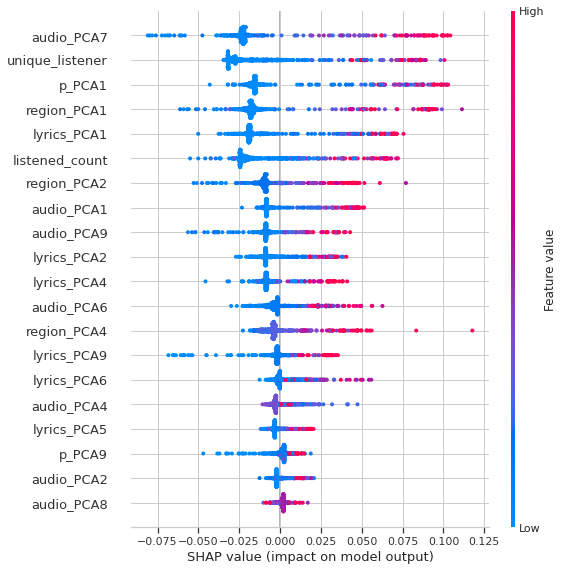

In [240]:
# Checking shap values
shap.initjs()
shap_df = X_fulltrain
explainer = shap.TreeExplainer(chosen_rfc[2])
shap_values = explainer.shap_values(shap_df, approximate=False, check_additivity=False)
shap.summary_plot(shap_values[1], shap_df, show=False)

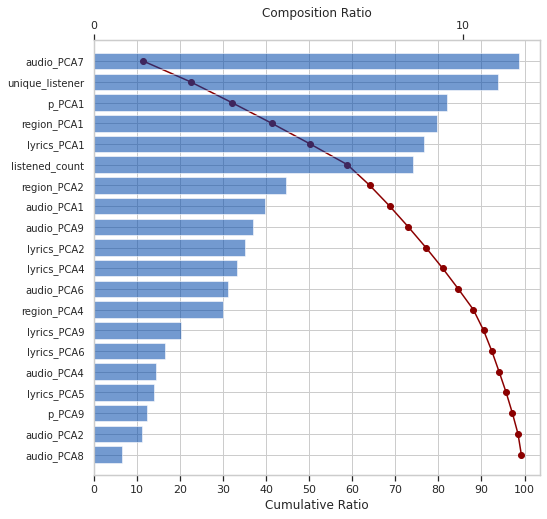

In [241]:
def make_shap_waterfall_plot(shap_values, features, num_display=20): # Taken from Shopenova (2020)
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='darkred', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.55, color='#0047AB')
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=10)
    plt.ylim(-1, len(column_list))
    
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], shap_df)
plt.savefig('./Model_Evaluation_Images/composition_ratio.png')